# Проект оптимизации производственных расходов металлургического комбината с целью уменьшения потребления электроэнергии на этапе обработки стали.

# Описание проекта:
**Заказчик:** металлургический комбинат «Стальная птица» (далее - Заказчик)

**Цель проекта:** построить модель, для предсказания контролируемой температуры сплава (далее - Таргет) с целью оптимизации производственных расходов Заказчика (сокращения количества потребляемой электроэнергии на этапе обработки стали).

Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

# **Исходные данные**

Данные хранятся в Sqlite  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:

`steel.data_arc` — данные об электродах;

`steel.data_bulk` — данные об объёме сыпучих материалов;

`steel.data_bulk_time` — данные о времени подачи сыпучих материалов;

`steel.data_gas` — данные о продувке сплава газом;

`steel.data_temp` — данные об измерениях температуры;

`steel.data_wire` — данные об объёме проволочных материалов;

`steel.data_wire_time` — данные о времени подачи проволочных материалов.

##**План работы**
1. Загрузка данных
2. Исследовательский анализ и предобработка данных
  - Проверка наличия данных в таблицах.
  - Проверка соответствия количества таблиц условию задачи.
  - Анализ и предобработка исходных данных.
3. Обучение моделей
  - константная модель;
  - линейные модели;
  - линейные модели;
  - бустинги;
  - нейронная сеть.
4. Тестирвоание лучгшей модели
  - Проверка качества лучшей модели на тестовой выборке. (Значение метрики MAE должно быть менее 6.8).
  - Сравнение результата лучшей и константной моделей.
  - Анализ важности основных признаков.
  - График зависимости одного из входных и целевого признаков.
5. Общий вывод по работе и рекомендации Заказчику


# 0 Подготовка ноутбука к работе

In [1]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from shap import LinearExplainer, summary_plot

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from catboost.utils import get_gpu_device_count


import torch
import torch.nn as nn
import torch.utils.data

Функции

In [5]:
# Function to display main info
def display_main_info(df):
    print('________________Head________________')
    display(df.head())
    print('________________Data Types Info________________')
    display(df.info())
    print('________________Shape________________')
    display(df.shape)
    print('________________Duplicates________________')
    display(df.duplicated().sum())
    print('________________Proportion of Missing Data________________')
    display(df.isna().mean())

In [6]:
# Function to display statistical info
def show_stats(df, column_name):
    print(f'Statics for {column_name}')
    display(df[[column_name]].describe().T)

In [7]:
# Function to display distribution
def plot_density_and_boxplot(data, column):

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot density plot
    sns.histplot(data[column], bins=50, color='lightgreen', kde=True, ax=axs[0])
    axs[0].set_title(f'Density Plot of {column}')

    # Plot boxplot
    axs[1].boxplot(data[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axs[1].set_title(f'Boxplot of {column}')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

Константы

In [8]:
RANDOM_STATE = 210425

# 1. Загрузка данных

In [9]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db

--2025-05-01 09:12:56--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.15’

ds-plus-final.db.15 100%[===================>]   3.42M  11.3MB/s    in 0.3s    

2025-05-01 09:12:57 (11.3 MB/s) - ‘ds-plus-final.db.15’ saved [3588096/3588096]



In [10]:
import os
import pandas as pd
from sqlalchemy import create_engine

path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

In [11]:
# Получаем список всех таблиц в базе данных
with engine.connect() as conn:
    tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)['name'].tolist()

In [12]:
print(f"Обнаружено таблиц в базе данных: {len(tables)}")
print("Список таблиц:", tables)

Обнаружено таблиц в базе данных: 11
Список таблиц: ['data_arc', 'data_bulk', 'data_bulk_time', 'data_wire_time', 'contract', 'personal', 'phone', 'internet', 'data_gas', 'data_temp', 'data_wire']


In [13]:
for table in tables:
  print(f'\n========== Top 5 rows of {table} ==========')
  df = pd.read_sql(f"SELECT * FROM {table} LIMIT 5", engine)
  print(df)


========== Top 5 rows of data_arc ==========
   key Начало нагрева дугой  Конец нагрева дугой  Активная мощность  \
0    1  2019-05-03 11:02:14  2019-05-03 11:06:02           0.305130   
1    1  2019-05-03 11:07:28  2019-05-03 11:10:33           0.765658   
2    1  2019-05-03 11:11:44  2019-05-03 11:14:36           0.580313   
3    1  2019-05-03 11:18:14  2019-05-03 11:24:19           0.518496   
4    1  2019-05-03 11:26:09  2019-05-03 11:28:37           0.867133   

   Реактивная мощность  
0             0.211253  
1             0.477438  
2             0.430460  
3             0.379979  
4             0.643691  

========== Top 5 rows of data_bulk ==========
   key Bulk 1 Bulk 2 Bulk 3  Bulk 4 Bulk 5 Bulk 6 Bulk 7 Bulk 8 Bulk 9  \
0    1   None   None   None    43.0   None   None   None   None   None   
1    2   None   None   None    73.0   None   None   None   None   None   
2    3   None   None   None    34.0   None   None   None   None   None   
3    4   None   None   None    81.

**Наблюдения:**

Все необходимые для исслеодования таблицы присутсвтую в БД:

`steel.data_arc` — данные об электродах;

`steel.data_bulk`— данные об объёме сыпучих материалов;


`steel.data_bulk_time` — данные о времени подачи сыпучих материалов;

`steel.data_gas` — данные о продувке сплава газом;

`steel.data_temp` — данные об измерениях температуры;

`steel.data_wire` — данные об объёме проволочных материалов;

`steel.data_wire_time` — данные о времени подачи проволочных материалов.

Также, присутсвует ряд дополнительных таблиц, которые использованы не будут.

Также, отмечается наличие пропусков, однако, это будет рассмотрено далее.

# 2. EDA

## 2.1. Таблица `data_arc`

Таблица data_arc содержит данные об электродах:

`key` — номер партии;

`BeginHeat` — время начала нагрева;

`EndHeat` — время окончания нагрева;

`ActivePower` — значение активной мощности;

`ReactivePower` — значение реактивной мощности.

In [14]:
data_arc = pd.read_sql_query('SELECT * FROM data_arc', engine, parse_dates=['Начало нагрева дугой',	'Конец нагрева дугой'])

In [15]:
display_main_info(data_arc)

________________Head________________


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


None

________________Shape________________


(14876, 5)

________________Duplicates________________


0

________________Proportion of Missing Data________________


key                     0.0
Начало нагрева дугой    0.0
Конец нагрева дугой     0.0
Активная мощность       0.0
Реактивная мощность     0.0
dtype: float64

In [16]:
data_arc.columns = ['key', 'BeginHeat', 'EndHeat', 'ActivePower', 'ReactivePower']

In [17]:
show_stats(data_arc, 'ActivePower')

Statics for ActivePower


,count,mean,std,min,25%,50%,75%,max
ActivePower,14876.0,0.662752,0.258885,0.22312,0.467115,0.599587,0.83007,1.463773


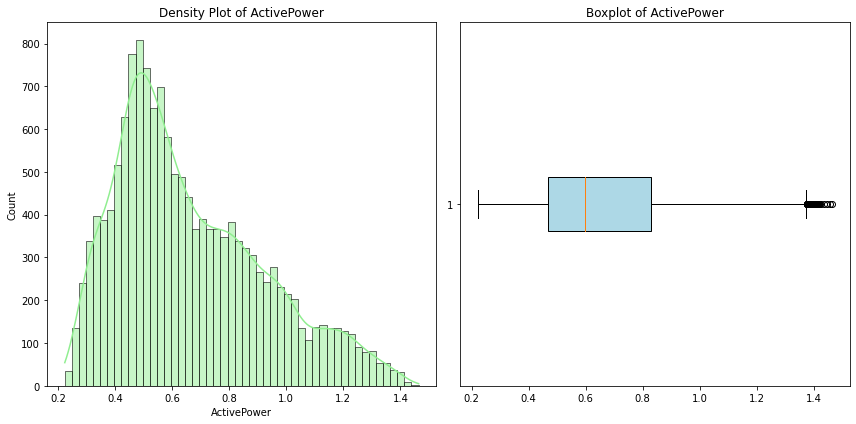

In [18]:
plot_density_and_boxplot(data_arc, 'ActivePower')

Наблюдения:

Распределение слегка скошено вправо: медиана (0.6) меньше среднего (0.66), значит есть небольшое влияние высоких значений.

Значения лежат в диапазоне примерно от 0.22 до 1.46.

Дисперсия умеренная (стандартное отклонение около 0.26 на фоне среднего в 0.66).

In [19]:
show_stats(data_arc, 'ReactivePower')

Statics for ReactivePower


,count,mean,std,min,25%,50%,75%,max
ReactivePower,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


Обнаружена ошибка в данных - отрицательное значение мощности.

In [20]:
data_arc = data_arc[data_arc['ReactivePower'] > 0]

In [21]:
show_stats(data_arc, 'ReactivePower')

Statics for ReactivePower


,count,mean,std,min,25%,50%,75%,max
ReactivePower,14875.0,0.487115,0.197612,0.153777,0.33719,0.441665,0.608223,1.270284


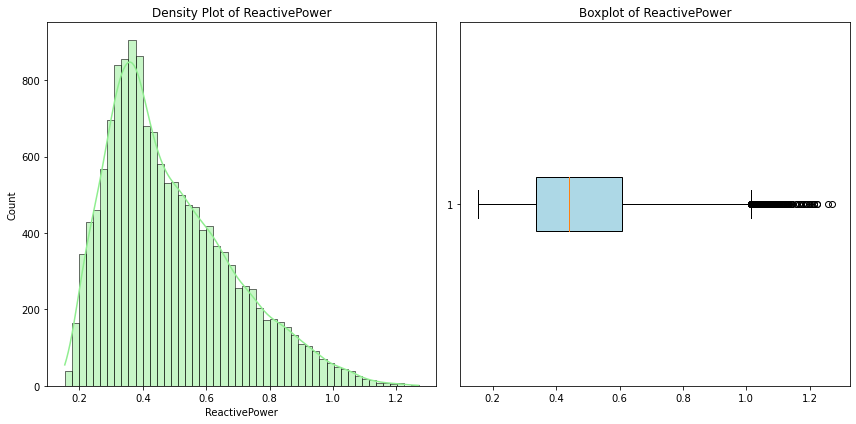

In [22]:
plot_density_and_boxplot(data_arc, 'ReactivePower')

Наблюдения:

После удаления выброса распределение ReactivePower нормальное, без явных выбросов.

Среднее (0.487) чуть больше медианы (0.442).

Разброс невелик (std ≈ 0.20 при среднем 0.49).

Значения лежат в диапазоне примерно от 0.15 до 1.27, что приемлимо.

Однако, необходимо учитывать, что ReactivePower обычно должна быть меньше ActivePower, так как реактивная мощность — это "паразитная" нагрузка, что соблюдается в данных: среднее ReactivePower ниже среднего ActivePower.

Однако, проверим построчно.

In [23]:
(data_arc['ActivePower'] > data_arc['ReactivePower']).all()

True

Условие соблюдается для всех наблюдений.

 ### Добавление новых признаков

Длительность нагрева

In [24]:
data_arc = data_arc.copy()
data_arc['DurationHeat'] = (data_arc['EndHeat'] - data_arc['BeginHeat']).dt.total_seconds()

In [25]:
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,DurationHeat
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0


Общая мощность

In [26]:
data_arc['TotalPower'] = (data_arc['ActivePower']**2 + data_arc['ReactivePower']**2)**0.5

Коэффициент мощности (PowerFactor) насколько эффективно используется энергия

In [27]:
data_arc['PowerFactor'] = data_arc['ActivePower'] / data_arc['TotalPower']

Отношение активной мощности к реактивной

In [28]:
data_arc['RatioPower'] = data_arc['ActivePower'] / data_arc['ReactivePower']

Количество запуска нагрева электродами

In [29]:
num_heats = data_arc.groupby('key').size().reset_index(name='NumHeats')

In [30]:
data_arc = data_arc.merge(num_heats, on='key', how='left')

In [31]:
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower,DurationHeat,TotalPower,PowerFactor,RatioPower,NumHeats
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,0.822181,1.444382,5
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,0.848545,1.603680,5
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,0.803161,1.348123,5
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,0.806591,1.364539,5
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,0.802950,1.347126,5


Аггрегирование

In [32]:
agg_funcs = {
    'BeginHeat': 'min',
    'EndHeat': 'max',
    'ActivePower': ['mean', 'max', 'min'],
    'ReactivePower': ['mean', 'max', 'min'],
    'TotalPower': ['mean', 'max', 'min'],
    'PowerFactor': ['mean', 'min'],
    'RatioPower': ['mean'],
    'DurationHeat': 'sum',
    'NumHeats': 'first'
}

data_arc_agg = data_arc.groupby('key').agg(agg_funcs)

data_arc_agg.columns = ['_'.join(col).strip() for col in data_arc_agg.columns.values]
data_arc_agg = data_arc_agg.reset_index()

In [33]:
data_arc_agg.head()

,key,BeginHeat_min,EndHeat_max,ActivePower_mean,ActivePower_max,ActivePower_min,ReactivePower_mean,ReactivePower_max,ReactivePower_min,TotalPower_mean,TotalPower_max,TotalPower_min,PowerFactor_mean,PowerFactor_min,RatioPower_mean,DurationHeat_sum,NumHeats_first
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.867133,0.305130,0.428564,0.643691,0.211253,0.743747,1.079934,0.371123,0.816686,0.802950,1.421570,1098.0,5
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.786322,0.261665,0.363339,0.542517,0.205527,0.647087,0.955315,0.332731,0.825276,0.786416,1.479201,811.0,4
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,1.222963,0.421693,0.587491,0.863676,0.272562,1.003845,1.497189,0.502111,0.809724,0.752692,1.396069,655.0,5
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.887855,0.310693,0.514248,0.654661,0.241781,0.850010,1.097105,0.393685,0.793923,0.779854,1.307446,741.0,4
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.892957,0.324563,0.421998,0.660807,0.279102,0.704245,1.110873,0.428064,0.796818,0.758211,1.328894,869.0,4


## 2.2. Таблица `data_bulk`

Данные об объёме сыпучих материалов:

`key` — номер партии;

`Bulk1` … `Bulk15` — объём подаваемого материала.


In [34]:
data_bulk = pd.read_sql('SELECT * FROM data_bulk', engine)

In [35]:
display_main_info(data_bulk)

________________Head________________


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


None

________________Shape________________


(3129, 16)

________________Duplicates________________


0

________________Proportion of Missing Data________________


key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

In [36]:
cols_to_change = data_bulk.select_dtypes(exclude='number').columns.tolist()

In [37]:
for col in cols_to_change:
  data_bulk[col] = data_bulk[col].astype(float)


Обработка NaN

Т.к. в соответствии с ТЗ пропуск означает, что материал не добавляли в партию, значения NaN будут заменены на 0.

In [38]:
data_bulk = data_bulk.fillna(0)

Statics for Bulk 1


,count,mean,std,min,25%,50%,75%,max
Bulk 1,3129.0,3.160435,11.869164,0.0,0.0,0.0,0.0,185.0


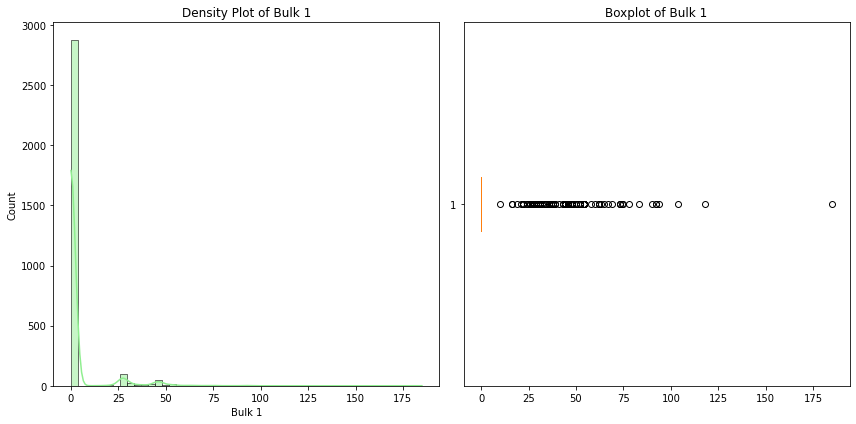

Statics for Bulk 2


,count,mean,std,min,25%,50%,75%,max
Bulk 2,3129.0,1.779163,21.217878,0.0,0.0,0.0,0.0,325.0


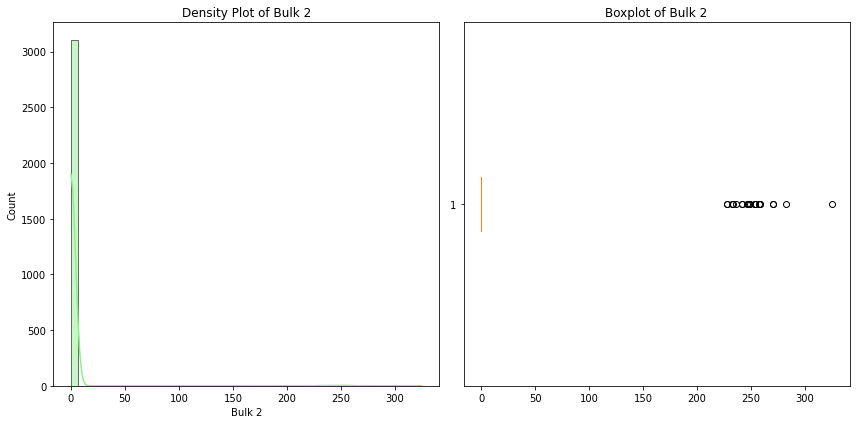

Statics for Bulk 3


,count,mean,std,min,25%,50%,75%,max
Bulk 3,3129.0,47.240332,74.239954,0.0,0.0,0.0,80.0,454.0


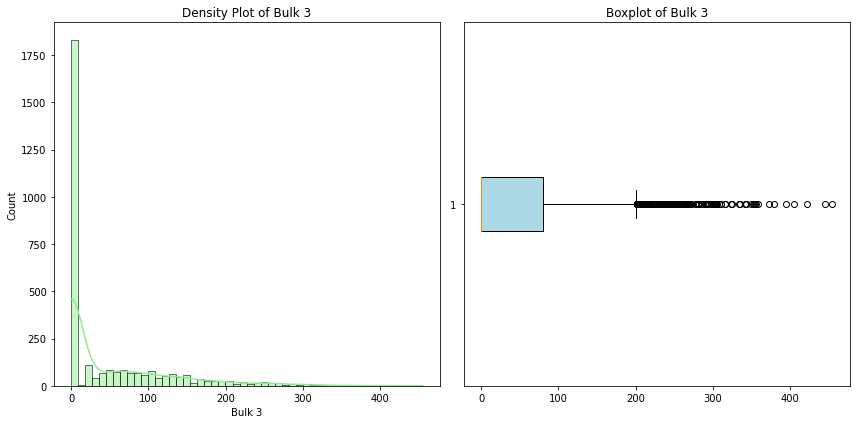

Statics for Bulk 4


,count,mean,std,min,25%,50%,75%,max
Bulk 4,3129.0,33.830617,56.034505,0.0,0.0,0.0,68.0,281.0


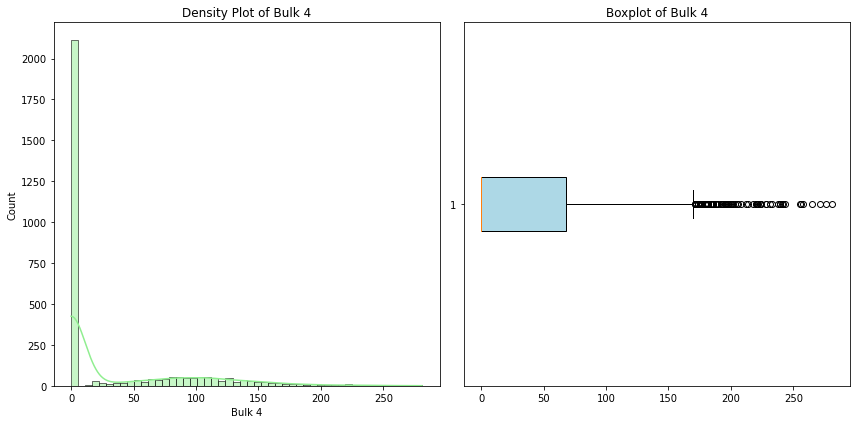

Statics for Bulk 5


,count,mean,std,min,25%,50%,75%,max
Bulk 5,3129.0,2.633749,20.918138,0.0,0.0,0.0,0.0,603.0


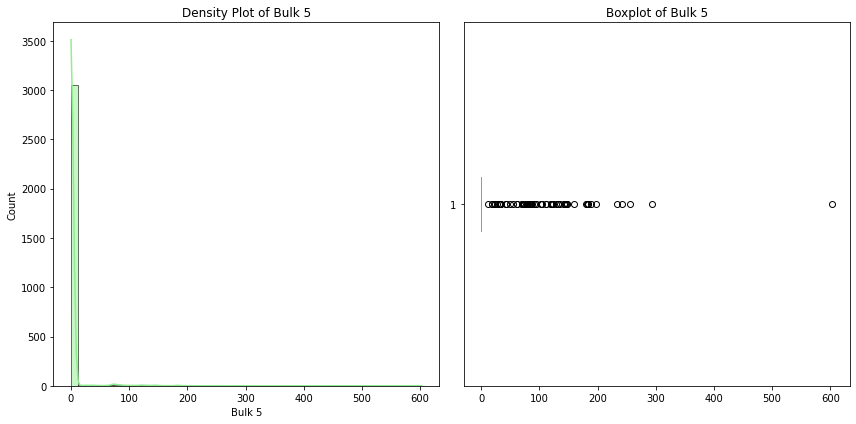

Statics for Bulk 6


,count,mean,std,min,25%,50%,75%,max
Bulk 6,3129.0,21.892298,55.492582,0.0,0.0,0.0,0.0,503.0


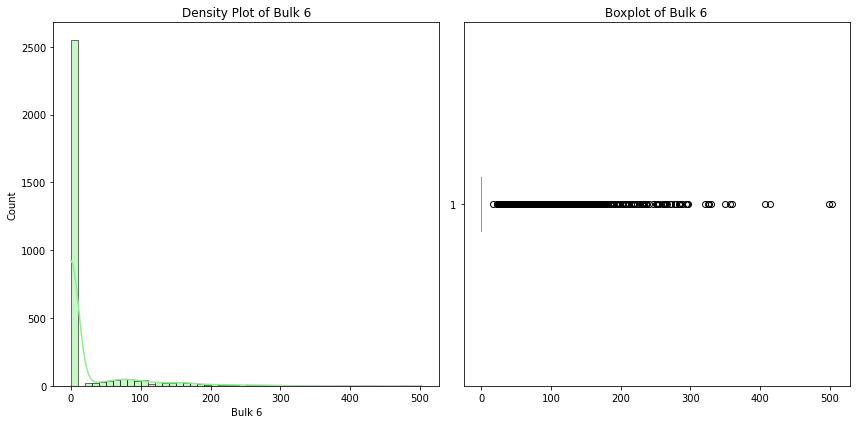

Statics for Bulk 7


,count,mean,std,min,25%,50%,75%,max
Bulk 7,3129.0,2.441675,31.944063,0.0,0.0,0.0,0.0,772.0


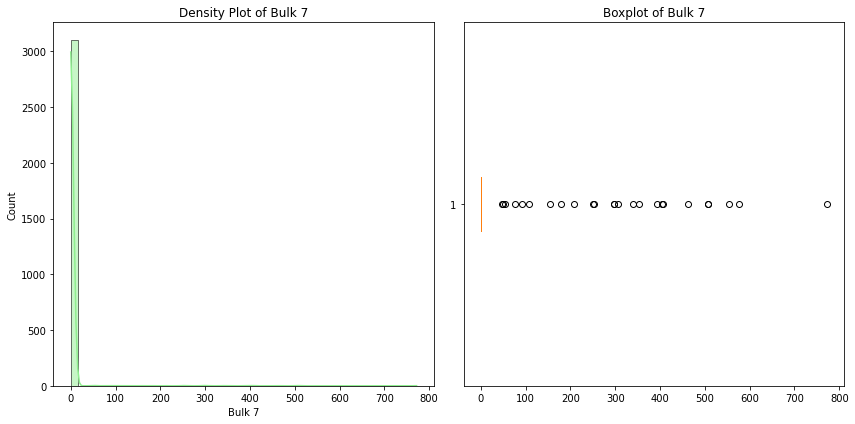

Statics for Bulk 8


,count,mean,std,min,25%,50%,75%,max
Bulk 8,3129.0,0.01566,0.875978,0.0,0.0,0.0,0.0,49.0


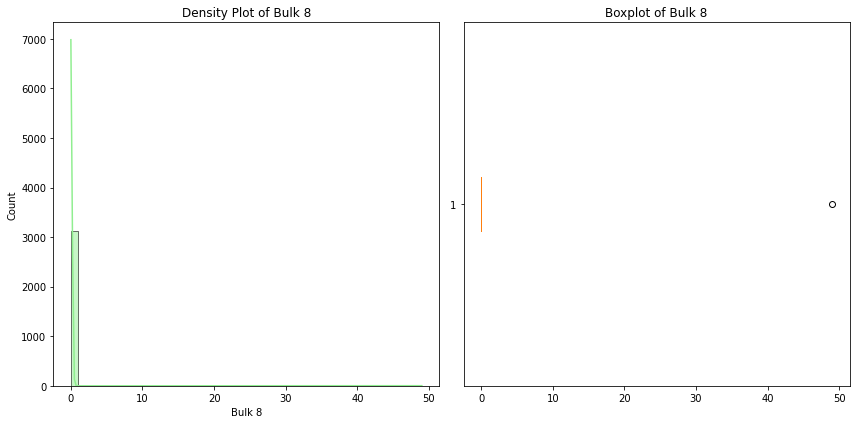

Statics for Bulk 9


,count,mean,std,min,25%,50%,75%,max
Bulk 9,3129.0,0.463407,6.154398,0.0,0.0,0.0,0.0,147.0


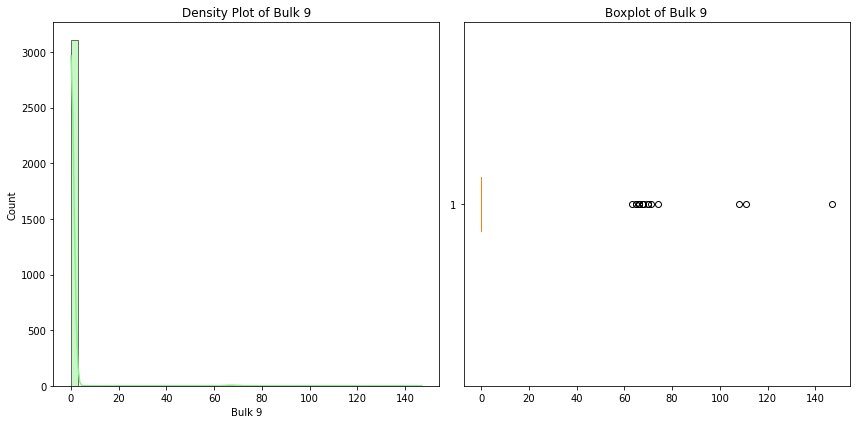

Statics for Bulk 10


,count,mean,std,min,25%,50%,75%,max
Bulk 10,3129.0,4.684564,20.157323,0.0,0.0,0.0,0.0,159.0


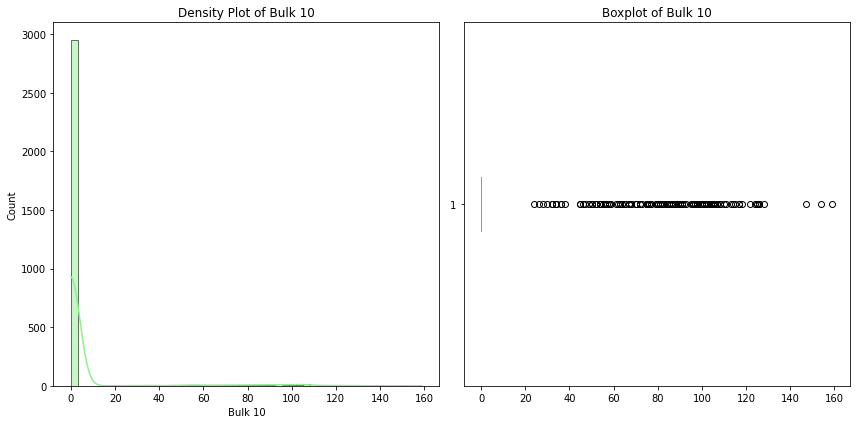

Statics for Bulk 11


,count,mean,std,min,25%,50%,75%,max
Bulk 11,3129.0,4.345478,22.69958,0.0,0.0,0.0,0.0,313.0


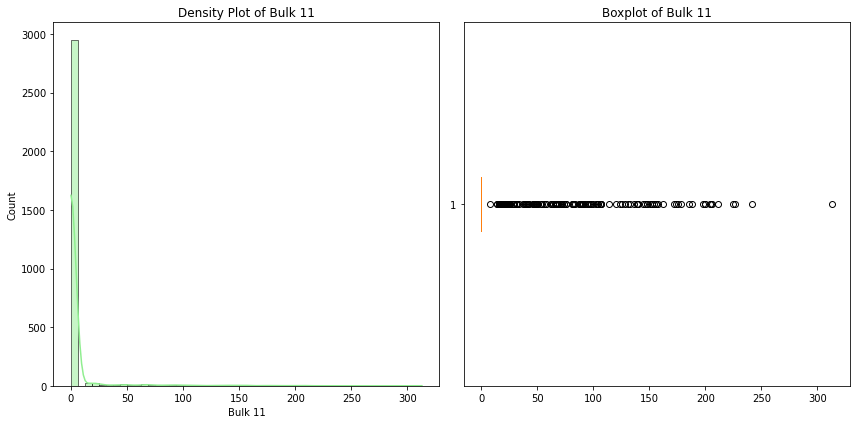

Statics for Bulk 12


,count,mean,std,min,25%,50%,75%,max
Bulk 12,3129.0,203.948226,151.419639,0.0,105.0,206.0,263.0,1849.0


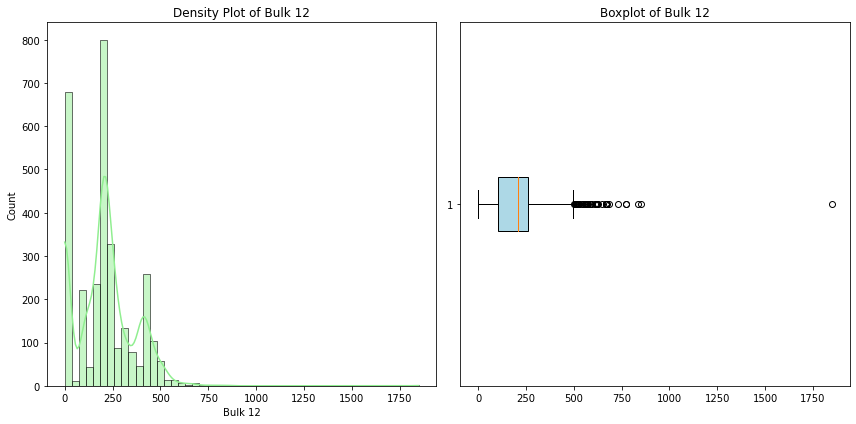

Statics for Bulk 13


,count,mean,std,min,25%,50%,75%,max
Bulk 13,3129.0,1.041866,14.114252,0.0,0.0,0.0,0.0,305.0


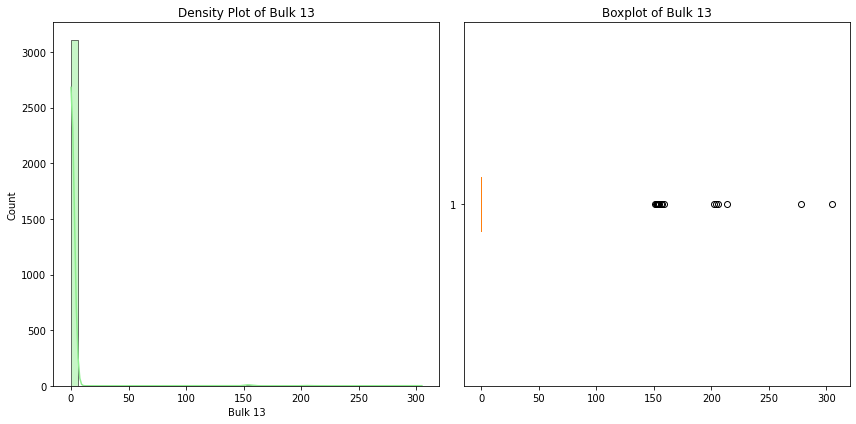

Statics for Bulk 14


,count,mean,std,min,25%,50%,75%,max
Bulk 14,3129.0,152.706616,81.091421,0.0,104.0,148.0,202.0,636.0


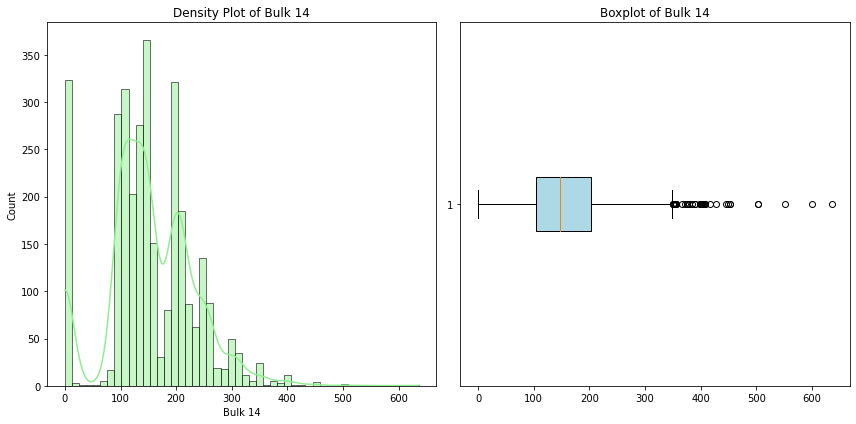

Statics for Bulk 15


,count,mean,std,min,25%,50%,75%,max
Bulk 15,3129.0,115.319271,84.488698,0.0,0.0,106.0,204.0,405.0


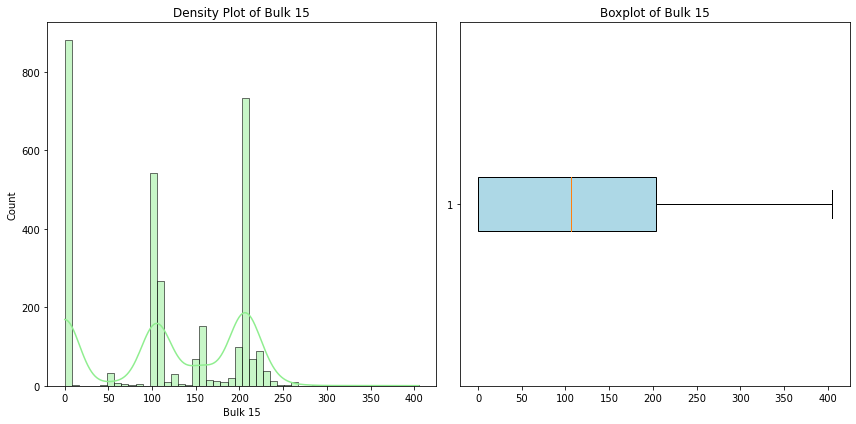

In [39]:
for col in data_bulk.drop(columns='key').columns:
  show_stats(data_bulk, col)
  plot_density_and_boxplot(data_bulk, col)

Распределения скошенные и боксплот показывает "выбросы". Однако, нельзя утвержать, что это аномалии, учтывая, что в некотрых случаях тот или иной сыпучий материал не участвует в технологическом процессе.

In [40]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


## 2.3. Таблица `data_bulk_time`

Данные о времени подачи сыпучих материалов:

`key` — номер партии;

`Bulk1` … `Bulk15` — время подачи материала.

In [41]:
cols_to_parse = [f'Bulk {i}' for i in range(1, 16)]

In [42]:
data_bulk_time = pd.read_sql('SELECT * FROM data_bulk_time', engine, parse_dates=cols_to_parse)

In [43]:
display_main_info(data_bulk_time)

________________Head________________


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1

None

________________Shape________________


(3129, 16)

________________Duplicates________________


0

________________Proportion of Missing Data________________


key        0.000000
Bulk 1     0.919463
Bulk 2     0.992969
Bulk 3     0.585171
Bulk 4     0.675935
Bulk 5     0.975391
Bulk 6     0.815916
Bulk 7     0.992010
Bulk 8     0.999680
Bulk 9     0.993928
Bulk 10    0.943752
Bulk 11    0.943432
Bulk 12    0.217002
Bulk 13    0.994247
Bulk 14    0.103228
Bulk 15    0.281560
dtype: float64

Анализ длительности

In [44]:
cols = data_bulk_time.drop(columns='key').columns

# Минимальное и максимальное время подачи по партии
data_bulk_time['FirstBulkTime'] = data_bulk_time[cols].min(axis=1)
data_bulk_time['LastBulkTime'] = data_bulk_time[cols].max(axis=1)

# Длительность между первой и последней подачей в секундах
data_bulk_time['BulkFeedingDuration_sec'] = (
    (data_bulk_time['LastBulkTime'] - data_bulk_time['FirstBulkTime']).dt.total_seconds()
)

In [45]:
show_stats(data_bulk_time, 'BulkFeedingDuration_sec')

Statics for BulkFeedingDuration_sec


,count,mean,std,min,25%,50%,75%,max
BulkFeedingDuration_sec,3129.0,964.906679,798.088025,0.0,485.0,877.0,1311.0,13683.0


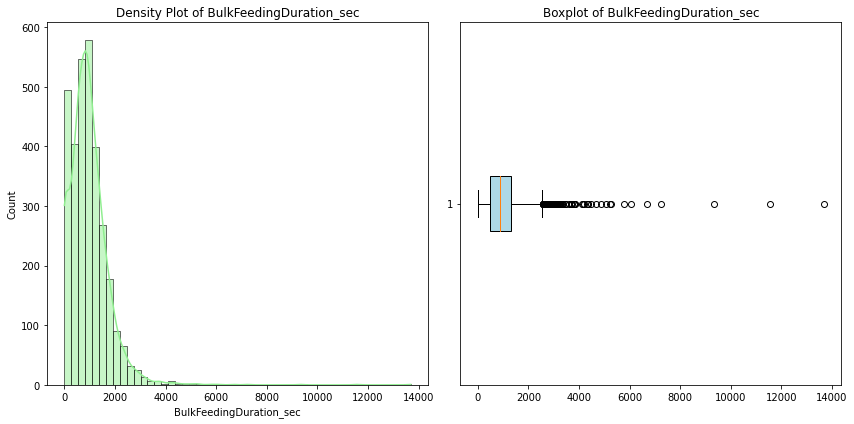

In [46]:
plot_density_and_boxplot(data_bulk_time, 'BulkFeedingDuration_sec')

Такие статистические показатели, как count, mean, std, медиана не вызывают вопросов.

Однако, есть большие длительности (≈ 3 часа 48 минут).

В среднем подача идёт 15-20 минут, а тут почти 4 часа. Может быть реально долгий процесс, стоит уточнить у Заказчика.

Добавление дополнительных признаков

Была ли хотя бы одна подача

In [47]:
bulk_columns = [f'Bulk {i}' for i in range(1, 16)]

data_bulk_time['BulkFeeding_Flag'] = data_bulk_time[bulk_columns].notna().any(axis=1).astype(int)

Число подач

In [48]:
data_bulk_time['BulkFeeding_Count'] = data_bulk_time[bulk_columns].notna().sum(axis=1)

Средний интервал между подачами

In [49]:
def avg_bulk_interval(row):
    times = row[bulk_columns].dropna().sort_values()
    if len(times) > 1:
        diffs = (times.diff().dropna()).dt.total_seconds()
        return diffs.mean()
    else:
        return 0

data_bulk_time['BulkFeeding_AvgInterval_sec'] = data_bulk_time.apply(avg_bulk_interval, axis=1)

In [50]:
data_bulk_time = data_bulk_time.drop(columns=bulk_columns)

In [51]:
data_bulk_time.head()

,key,FirstBulkTime,LastBulkTime,BulkFeedingDuration_sec,BulkFeeding_Flag,BulkFeeding_Count,BulkFeeding_AvgInterval_sec
0,1,2019-05-03 11:10:43,2019-05-03 11:28:48,1085.0,1,4,361.666667
1,2,2019-05-03 11:36:50,2019-05-03 11:53:30,1000.0,1,4,333.333333
2,3,2019-05-03 12:16:16,2019-05-03 12:32:39,983.0,1,4,327.666667
3,4,2019-05-03 12:43:22,2019-05-03 12:58:00,878.0,1,4,292.666667
4,5,2019-05-03 13:30:47,2019-05-03 13:34:12,205.0,1,4,68.333333


## 2.4. Таблица `data_gas`

Данные о продувке сплава газом.

`key` — номер партии;

`gas` — объём подаваемого газа.

In [52]:
data_gas = pd.read_sql('SELECT * FROM data_gas', engine)

In [53]:
display_main_info(data_gas)

________________Head________________


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

________________Shape________________


(3239, 2)

________________Duplicates________________


0

________________Proportion of Missing Data________________


key      0.0
Газ 1    0.0
dtype: float64

In [54]:
data_gas = data_gas.rename(columns={'Газ 1': 'Gas1'})

In [55]:
show_stats(data_gas, 'Gas1')

Statics for Gas1


,count,mean,std,min,25%,50%,75%,max
Gas1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


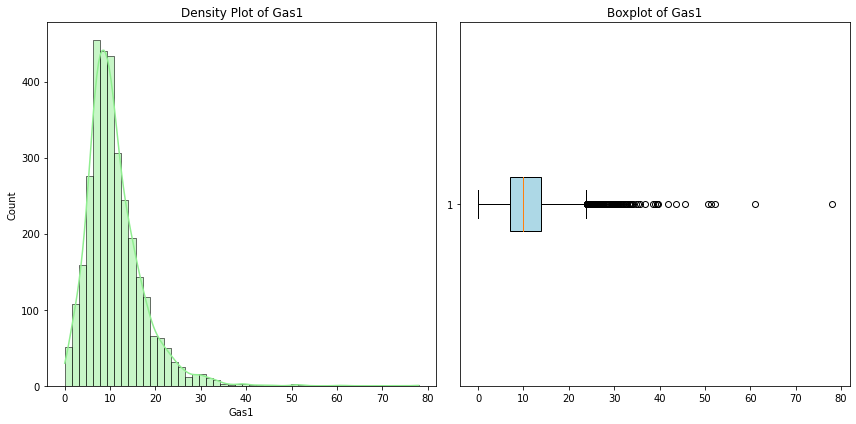

In [56]:
plot_density_and_boxplot(data_gas, 'Gas1')

Есть выбивающиеся максимальные значения. Однако, нельзя утвержать без согласования Заказчика, что это ошибка в данных.

## 2.5. Таблица `data_temp`


Данные об измерениях температуры:

`key` — номер партии;

`MesaureTime` — время замера;

`Temperature` — значение температуры.

In [57]:
data_temp = pd.read_sql_query('SELECT * FROM data_temp', engine, parse_dates=['Время замера'])

In [58]:
display_main_info(data_temp)

________________Head________________


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 424.2+ KB


None

________________Shape________________


(18092, 3)

________________Duplicates________________


0

________________Proportion of Missing Data________________


key             0.000000
Время замера    0.000000
Температура     0.189421
dtype: float64

In [59]:
data_temp.columns = ['key', 'MeasureTime', 'Temperature']

In [60]:
data_temp['Temperature'] = data_temp['Temperature'].astype(float)

Есть пропуски. Можно попробовать щаполнить средним по партии.

In [61]:
show_stats(data_temp, 'Temperature')

Statics for Temperature


,count,mean,std,min,25%,50%,75%,max
Temperature,14665.0,1590.722741,20.394381,1191.0,1580.0,1590.0,1599.0,1705.0


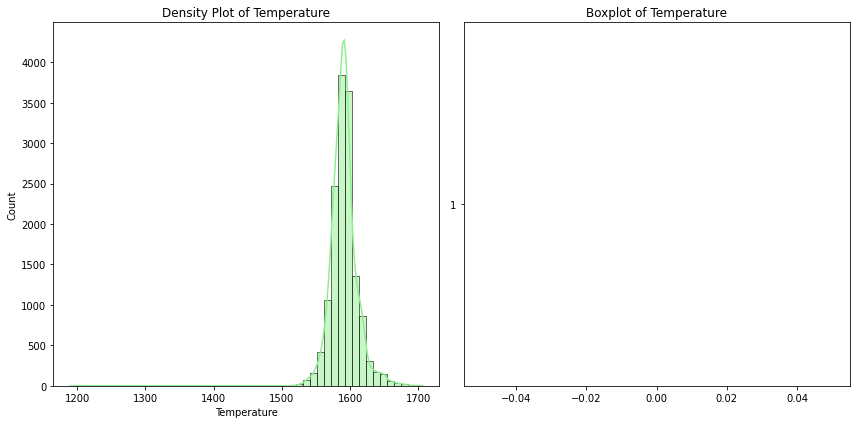

In [62]:
plot_density_and_boxplot(data_temp, 'Temperature')

В соответствии с ТЗ, значения температуры ниже 1500 градусов — аномальные. Их следует удалить.

In [63]:
data_temp = data_temp[data_temp['Temperature'] >= 1500]

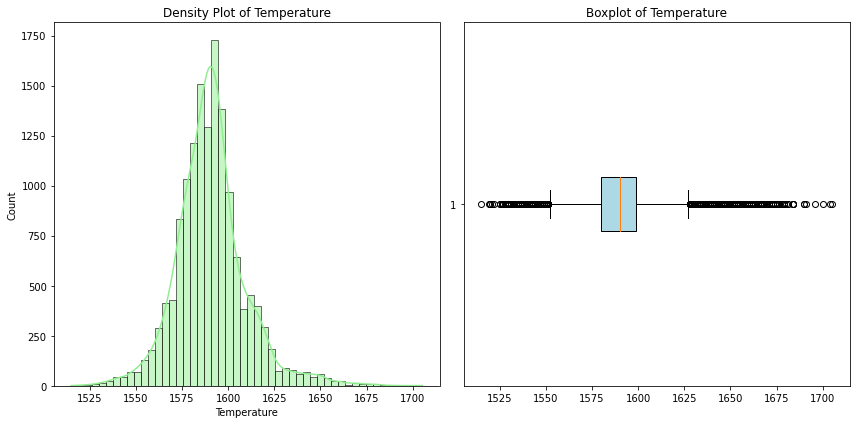

In [64]:
plot_density_and_boxplot(data_temp, 'Temperature')

Распределение нормальное.

Формирование Таргета

In [65]:
# Сначала считаем количество замеров на каждую партию
key_counts = data_temp['key'].value_counts()

# Оставляем только те ключи, где замеров 2 и больше
valid_keys = key_counts[key_counts >= 2].index

# Фильтруем датафрейм
data_temp_valid = data_temp[data_temp['key'].isin(valid_keys)]

# Теперь делаем группировку и берём первый и последний замеры
temp_summary = data_temp_valid.sort_values(['key', 'MeasureTime']).groupby('key').agg(
    FirstTemperature=('Temperature', 'first'),
    LastTemperature=('Temperature', 'last')
).reset_index()

In [66]:
temp_summary.head()

,key,FirstTemperature,LastTemperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


## 2.6. Таблица `data_wire`

Данные об объёме проволочных материалов:

`key` — номер партии;

`Wire1` … `Wire9` — объём подаваемых проволочных материалов.

In [67]:
data_wire = pd.read_sql_query('SELECT * FROM data_wire', engine)

In [68]:
wire_cols = [f'Wire {i}' for i in range(2, 10)]

In [69]:
display_main_info(data_wire)

________________Head________________


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


None

________________Shape________________


(3081, 10)

________________Duplicates________________


0

________________Proportion of Missing Data________________


key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

In [70]:
for col in wire_cols:
  data_wire[col] = data_wire[col].astype(float)

В соответствии с ТЗ пропуск означает, что материал не добавляли в эту партию.

In [71]:
data_wire = data_wire.fillna(0)

In [72]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.7. Таблица `data_wire_time`

Данные о времени подачи проволочных:

`key` — номер партии;

`Wire1` … `Wire9` — время подачи проволочных материалов.

In [73]:
date_cols = [f'Wire {i}' for i in range(1, 10)]

In [74]:
data_wire_time = pd.read_sql_query('SELECT * FROM data_wire_time', engine, parse_dates=date_cols)

In [75]:
display_main_info(data_wire_time)

________________Head________________


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


None

________________Shape________________


(3081, 10)

________________Duplicates________________


0

________________Proportion of Missing Data________________


key       0.000000
Wire 1    0.008439
Wire 2    0.649789
Wire 3    0.979552
Wire 4    0.995456
Wire 5    0.999675
Wire 6    0.976306
Wire 7    0.996430
Wire 8    0.993833
Wire 9    0.990587
dtype: float64

In [76]:
wire_columns = [f'Wire {i}' for i in range(1, 10)]

In [77]:
# Минимальное и максимальное время подачи по партии
data_wire_time['FirstWireTime'] = data_wire_time[wire_columns].min(axis=1)
data_wire_time['LastWireTime'] = data_wire_time[wire_columns].max(axis=1)

# Длительность между первой и последней подачей в секундах
data_wire_time['WireFeedingDuration_sec'] = (
    (data_wire_time['LastWireTime'] - data_wire_time['FirstWireTime']).dt.total_seconds()
)

In [78]:
show_stats(data_wire_time, 'WireFeedingDuration_sec')

Statics for WireFeedingDuration_sec


,count,mean,std,min,25%,50%,75%,max
WireFeedingDuration_sec,3081.0,214.519312,396.131967,0.0,0.0,0.0,401.0,5937.0


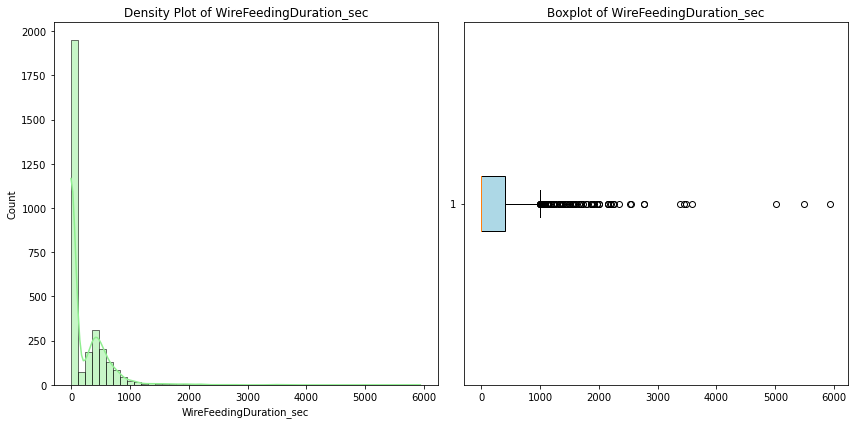

In [79]:
plot_density_and_boxplot(data_wire_time, 'WireFeedingDuration_sec')

**Наблюдения:**

- Медиана = 0 — больше половины партий либо использовали только один типа проволоки, либо вообще не использовали подачу проволоки.

- 75-й перцентиль = 401 секунд — четверть партий имела длительную подачу проволоки (от 401 секунды и выше).

- Среднее 214 секунд, но из-за перекоса (много нулей + редкие очень большие значения) оно сильно "съехало".

- Максимум = 5937 секунд — это почти 1.65 часа.
(5937 / 3600 ≈ 1.65). Однако, нельзя утверждать, что это ошибка в данных.

- Распределение очень смещённое влево (много нулей, редкие большие значения).


Добавление дополительных признаков

Была ли хотя бы одна подача

In [80]:
data_wire_time['WireFeeding_Flag'] = data_wire_time[wire_columns].notna().any(axis=1).astype(int)

Число подач

In [81]:
data_wire_time['WireFeeding_Count'] = data_wire_time[wire_columns].notna().sum(axis=1)

Средний интервал между подачами

In [82]:
def avg_wire_interval(row):
    times = row[wire_columns].dropna().sort_values()
    if len(times) > 1:
        diffs = (times.diff().dropna()).dt.total_seconds()
        return diffs.mean()
    else:
        return 0

data_wire_time['WireFeeding_AvgInterval_sec'] = data_wire_time.apply(avg_wire_interval, axis=1)


In [83]:
data_wire_time = data_wire_time.drop(columns=wire_columns)

In [84]:
data_wire_time.head()

,key,FirstWireTime,LastWireTime,WireFeedingDuration_sec,WireFeeding_Flag,WireFeeding_Count,WireFeeding_AvgInterval_sec
0,1,2019-05-03 11:06:19,2019-05-03 11:06:19,0.0,1,1,0.0
1,2,2019-05-03 11:36:50,2019-05-03 11:36:50,0.0,1,1,0.0
2,3,2019-05-03 12:11:46,2019-05-03 12:11:46,0.0,1,1,0.0
3,4,2019-05-03 12:43:22,2019-05-03 12:43:22,0.0,1,1,0.0
4,5,2019-05-03 13:15:34,2019-05-03 13:20:44,310.0,1,2,310.0


# 5. Формирование итогового датасета

In [85]:
df = (
    data_arc_agg
    .merge(data_bulk, how='inner', on='key')
    .merge(data_bulk_time, how='inner', on='key')
    .merge(data_gas, how='inner', on='key')
    .merge(temp_summary, how='inner', on='key')
    .merge(data_wire, how='inner', on='key')
    .merge(data_wire_time, how='inner', on='key')
)

In [86]:
display_main_info(df)

________________Head________________


,key,BeginHeat_min,EndHeat_max,ActivePower_mean,ActivePower_max,ActivePower_min,ReactivePower_mean,ReactivePower_max,ReactivePower_min,TotalPower_mean,...,Wire 6,Wire 7,Wire 8,Wire 9,FirstWireTime,LastWireTime,WireFeedingDuration_sec,WireFeeding_Flag,WireFeeding_Count,WireFeeding_AvgInterval_sec
0,1,2019-05-03 11:02:14,2019-05-03 11:28:37,0.607346,0.867133,0.305130,0.428564,0.643691,0.211253,0.743747,...,0.0,0.0,0.0,0.0,2019-05-03 11:06:19,2019-05-03 11:06:19,0.0,1,1,0.0
1,2,2019-05-03 11:34:14,2019-05-03 11:53:18,0.534852,0.786322,0.261665,0.363339,0.542517,0.205527,0.647087,...,0.0,0.0,0.0,0.0,2019-05-03 11:36:50,2019-05-03 11:36:50,0.0,1,1,0.0
2,3,2019-05-03 12:06:54,2019-05-03 12:32:19,0.812728,1.222963,0.421693,0.587491,0.863676,0.272562,1.003845,...,0.0,0.0,0.0,0.0,2019-05-03 12:11:46,2019-05-03 12:11:46,0.0,1,1,0.0
3,4,2019-05-03 12:39:37,2019-05-03 12:57:50,0.676622,0.887855,0.310693,0.514248,0.654661,0.241781,0.850010,...,0.0,0.0,0.0,0.0,2019-05-03 12:43:22,2019-05-03 12:43:22,0.0,1,1,0.0
4,5,2019-05-03 13:11:13,2019-05-03 13:33:55,0.563238,0.892957,0.324563,0.421998,0.660807,0.279102,0.704245,...,0.0,0.0,0.0,0.0,2019-05-03 13:15:34,2019-05-03 13:20:44,310.0,1,2,310.0


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   key                          2329 non-null   int64         
 1   BeginHeat_min                2329 non-null   datetime64[ns]
 2   EndHeat_max                  2329 non-null   datetime64[ns]
 3   ActivePower_mean             2329 non-null   float64       
 4   ActivePower_max              2329 non-null   float64       
 5   ActivePower_min              2329 non-null   float64       
 6   ReactivePower_mean           2329 non-null   float64       
 7   ReactivePower_max            2329 non-null   float64       
 8   ReactivePower_min            2329 non-null   float64       
 9   TotalPower_mean              2329 non-null   float64       
 10  TotalPower_max               2329 non-null   float64       


None

________________Shape________________


(2329, 56)

________________Duplicates________________


0

________________Proportion of Missing Data________________


key                            0.0
BeginHeat_min                  0.0
EndHeat_max                    0.0
ActivePower_mean               0.0
ActivePower_max                0.0
ActivePower_min                0.0
ReactivePower_mean             0.0
ReactivePower_max              0.0
ReactivePower_min              0.0
TotalPower_mean                0.0
TotalPower_max                 0.0
TotalPower_min                 0.0
PowerFactor_mean               0.0
PowerFactor_min                0.0
RatioPower_mean                0.0
DurationHeat_sum               0.0
NumHeats_first                 0.0
Bulk 1                         0.0
Bulk 2                         0.0
Bulk 3                         0.0
Bulk 4                         0.0
Bulk 5                         0.0
Bulk 6                         0.0
Bulk 7                         0.0
Bulk 8                         0.0
Bulk 9                         0.0
Bulk 10                        0.0
Bulk 11                        0.0
Bulk 12             

In [87]:
df = df.dropna()

In [88]:
cols_to_drop = [
    'key',
    'FirstBulkTime', 'LastBulkTime',
    'FirstWireTime', 'LastWireTime'
]

df = df.drop(columns=cols_to_drop)

In [89]:
# Преобразуем временные столбцы в количество секунд
df['BeginHeat_min'] = (df['BeginHeat_min'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df['EndHeat_max'] = (df['EndHeat_max'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

Отбор признаков будет осуществлён с помощью модели RandomForestRegressor и метода feature_importances_.

Корреляционный анализ произведён далее для линейных моделей.

In [90]:
X = df.drop(columns=['LastTemperature'])
y = df['LastTemperature']

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

importances = model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [91]:
print(feature_importance_df)

                        Feature  Importance
14             DurationHeat_sum    0.170251
36             FirstTemperature    0.166689
37                       Wire 1    0.084940
21                       Bulk 6    0.055783
35                         Gas1    0.037558
30                      Bulk 15    0.033593
38                       Wire 2    0.030745
29                      Bulk 14    0.028332
27                      Bulk 12    0.025754
12              PowerFactor_min    0.024368
31      BulkFeedingDuration_sec    0.023925
0                 BeginHeat_min    0.019900
1                   EndHeat_max    0.019372
34  BulkFeeding_AvgInterval_sec    0.019045
22                       Bulk 7    0.016906
13              RatioPower_mean    0.015682
4               ActivePower_min    0.015128
7             ReactivePower_min    0.014662
6             ReactivePower_max    0.013879
11             PowerFactor_mean    0.013347
46      WireFeedingDuration_sec    0.013272
18                       Bulk 3 

In [92]:
# Список отобранных признаков
selected_cols = [
    'DurationHeat_sum',
    'FirstTemperature',
    'Wire 1',
    'Bulk 6',
    'Gas1',
    'Bulk 15',
    'Wire 2',
    'Bulk 14',
    'Bulk 12',
    'PowerFactor_min',
    'BulkFeedingDuration_sec',
    'BeginHeat_min',
    'EndHeat_max',
    'BulkFeeding_AvgInterval_sec',
    'Bulk 7',
    'RatioPower_mean',
    'ActivePower_min',
    'ReactivePower_min',
    'ReactivePower_max',
    'PowerFactor_mean',
    'WireFeedingDuration_sec',
    'Bulk 3',
    'Bulk 4',
    'ActivePower_max',
    'ReactivePower_mean',
    'TotalPower_min',
    'ActivePower_mean',
    'NumHeats_first',
    'LastTemperature'
]

# Новый DataFrame с выбранными признаками
df_selected = df[selected_cols]

In [93]:
df_selected.head()

,DurationHeat_sum,FirstTemperature,Wire 1,Bulk 6,Gas1,Bulk 15,Wire 2,Bulk 14,Bulk 12,PowerFactor_min,...,PowerFactor_mean,WireFeedingDuration_sec,Bulk 3,Bulk 4,ActivePower_max,ReactivePower_mean,TotalPower_min,ActivePower_mean,NumHeats_first,LastTemperature
0,1098.0,1571.0,60.059998,0.0,29.749986,154.0,0.00000,150.0,206.0,0.802950,...,0.816686,0.0,0.0,43.0,0.867133,0.428564,0.371123,0.607346,5,1613.0
1,811.0,1581.0,96.052315,0.0,12.555561,154.0,0.00000,149.0,206.0,0.786416,...,0.825276,0.0,0.0,73.0,0.786322,0.363339,0.332731,0.534852,4,1602.0
2,655.0,1596.0,91.160157,0.0,28.554793,153.0,0.00000,152.0,205.0,0.752692,...,0.809724,0.0,0.0,34.0,1.222963,0.587491,0.502111,0.812728,5,1599.0
3,741.0,1601.0,89.063515,0.0,18.841219,154.0,0.00000,153.0,207.0,0.779854,...,0.793923,0.0,0.0,81.0,0.887855,0.514248,0.393685,0.676622,4,1625.0
4,869.0,1576.0,89.238236,0.0,5.413692,152.0,9.11456,151.0,203.0,0.758211,...,0.796818,310.0,0.0,78.0,0.892957,0.421998,0.428064,0.563238,4,1602.0


# 4. Обучение и выбор моделей

# 4.1. Разделение на выборки

In [94]:
X = df_selected.drop(columns='LastTemperature')
y = df_selected['LastTemperature']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=RANDOM_STATE
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1746, 28), (583, 28), (1746,), (583,))

# 4.2. Бэйзлайн

In [96]:
dummy_model = DummyRegressor(strategy='mean')

dummy_model.fit(X_train, y_train)
y_pred = dummy_model.predict(X_train)

mae = mean_absolute_error(y_train, y_pred)
print(f'MAE Dummy Regressor = {mae}')

MAE Dummy Regressor = 8.019551808158452


# 4.3. Линейные модели

В связи с тем, что все признаки представлены числами и не содержат категорий, начну с проверки линейной модели.

In [97]:
display_main_info(X_train)

________________Head________________


,DurationHeat_sum,FirstTemperature,Wire 1,Bulk 6,Gas1,Bulk 15,Wire 2,Bulk 14,Bulk 12,PowerFactor_min,...,ReactivePower_max,PowerFactor_mean,WireFeedingDuration_sec,Bulk 3,Bulk 4,ActivePower_max,ReactivePower_mean,TotalPower_min,ActivePower_mean,NumHeats_first
1433,813.0,1558.0,0.000000,0.0,18.137567,0.0,45.119358,152.0,0.0,0.743838,...,0.661207,0.806440,0.0,60.0,0.0,0.899800,0.474283,0.476894,0.644040,5
573,715.0,1601.0,103.942802,0.0,11.838655,202.0,0.000000,152.0,204.0,0.784742,...,0.840133,0.808181,0.0,0.0,56.0,1.141189,0.428282,0.407037,0.590945,5
939,738.0,1569.0,85.129196,252.0,12.096320,102.0,100.312157,202.0,129.0,0.793195,...,0.575716,0.816030,207.0,285.0,0.0,0.784745,0.425333,0.531072,0.602350,5
1375,795.0,1547.0,152.099991,0.0,9.586852,205.0,0.000000,119.0,254.0,0.768542,...,0.757200,0.791463,0.0,148.0,0.0,0.987796,0.651243,0.924669,0.846879,3
2116,1261.0,1558.0,100.201920,0.0,7.947217,209.0,0.000000,199.0,421.0,0.757795,...,0.843687,0.795756,0.0,250.0,0.0,1.142512,0.630718,0.630913,0.829523,6


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1746 entries, 1433 to 686
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DurationHeat_sum             1746 non-null   float64
 1   FirstTemperature             1746 non-null   float64
 2   Wire 1                       1746 non-null   float64
 3   Bulk 6                       1746 non-null   float64
 4   Gas1                         1746 non-null   float64
 5   Bulk 15                      1746 non-null   float64
 6   Wire 2                       1746 non-null   float64
 7   Bulk 14                      1746 non-null   float64
 8   Bulk 12                      1746 non-null   float64
 9   PowerFactor_min              1746 non-null   float64
 10  BulkFeedingDuration_sec      1746 non-null   float64
 11  BeginHeat_min                1746 non-null   int64  
 12  EndHeat_max               

None

________________Shape________________


(1746, 28)

________________Duplicates________________


0

________________Proportion of Missing Data________________


DurationHeat_sum               0.0
FirstTemperature               0.0
Wire 1                         0.0
Bulk 6                         0.0
Gas1                           0.0
Bulk 15                        0.0
Wire 2                         0.0
Bulk 14                        0.0
Bulk 12                        0.0
PowerFactor_min                0.0
BulkFeedingDuration_sec        0.0
BeginHeat_min                  0.0
EndHeat_max                    0.0
BulkFeeding_AvgInterval_sec    0.0
Bulk 7                         0.0
RatioPower_mean                0.0
ActivePower_min                0.0
ReactivePower_min              0.0
ReactivePower_max              0.0
PowerFactor_mean               0.0
WireFeedingDuration_sec        0.0
Bulk 3                         0.0
Bulk 4                         0.0
ActivePower_max                0.0
ReactivePower_mean             0.0
TotalPower_min                 0.0
ActivePower_mean               0.0
NumHeats_first                 0.0
dtype: float64

Statics for DurationHeat_sum


,count,mean,std,min,25%,50%,75%,max
DurationHeat_sum,1746.0,804.680985,347.784463,57.0,574.0,772.5,992.0,4189.0


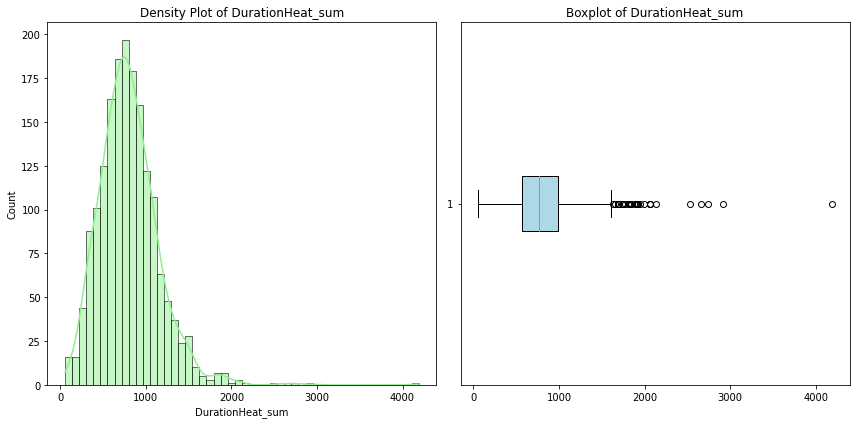

Statics for FirstTemperature


,count,mean,std,min,25%,50%,75%,max
FirstTemperature,1746.0,1587.109393,23.727079,1520.0,1571.0,1587.0,1603.0,1660.0


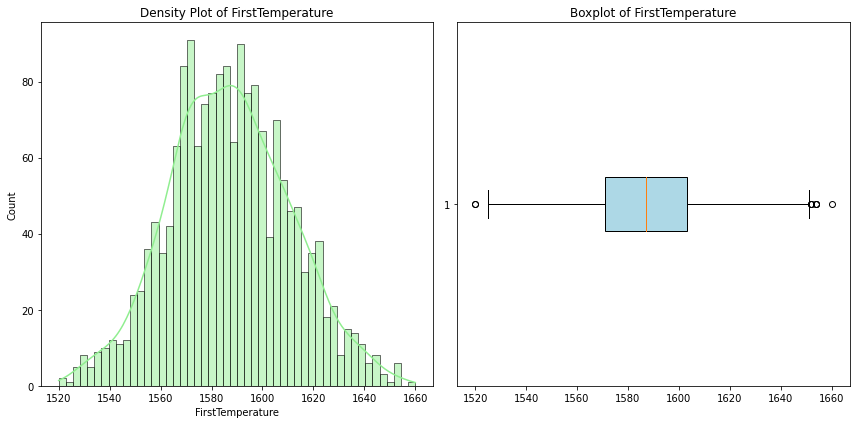

Statics for Wire 1


,count,mean,std,min,25%,50%,75%,max
Wire 1,1746.0,102.125906,43.308035,0.0,73.5813,101.462399,127.190693,330.314424


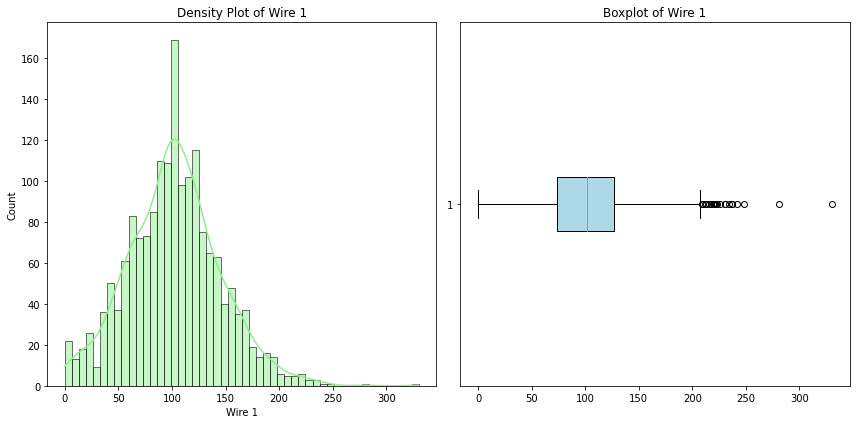

Statics for Bulk 6


,count,mean,std,min,25%,50%,75%,max
Bulk 6,1746.0,23.086483,56.408548,0.0,0.0,0.0,0.0,503.0


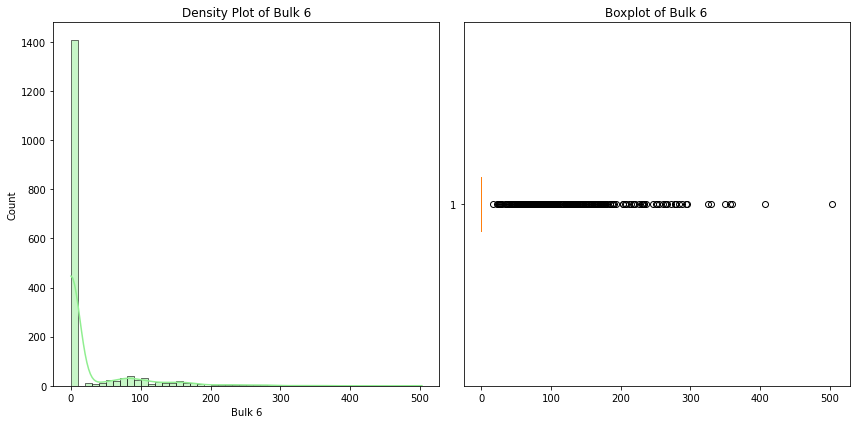

Statics for Gas1


,count,mean,std,min,25%,50%,75%,max
Gas1,1746.0,11.236138,6.2909,0.008399,7.220992,10.016304,13.870273,77.99504


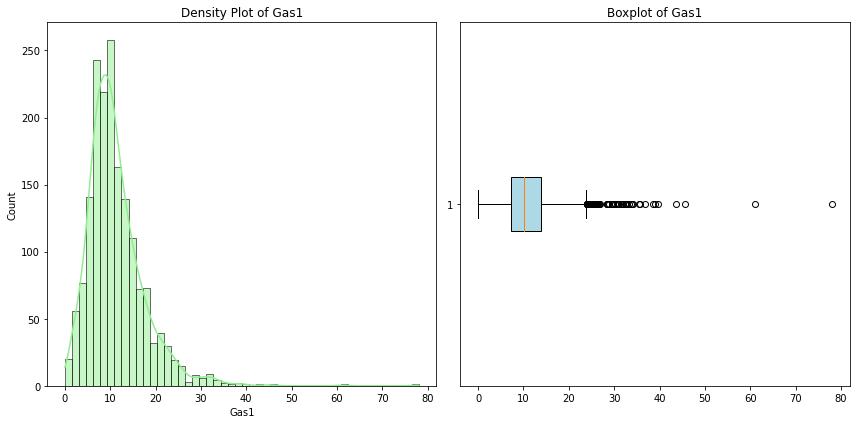

Statics for Bulk 15


,count,mean,std,min,25%,50%,75%,max
Bulk 15,1746.0,118.934708,85.075529,0.0,0.0,106.5,204.0,405.0


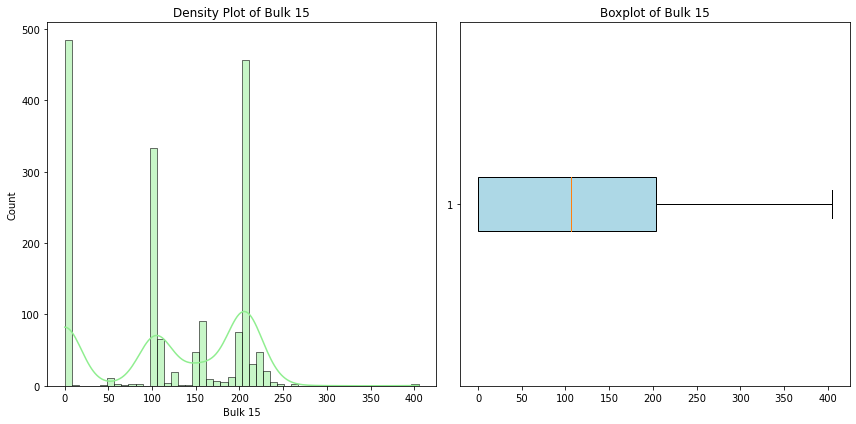

Statics for Wire 2


,count,mean,std,min,25%,50%,75%,max
Wire 2,1746.0,18.798272,34.770353,0.0,0.0,0.0,26.12012,282.780152


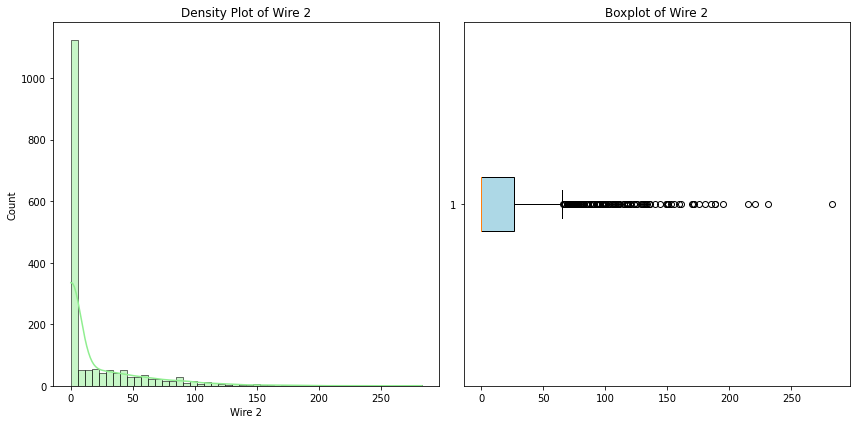

Statics for Bulk 14


,count,mean,std,min,25%,50%,75%,max
Bulk 14,1746.0,151.967354,82.013121,0.0,105.0,149.0,203.0,636.0


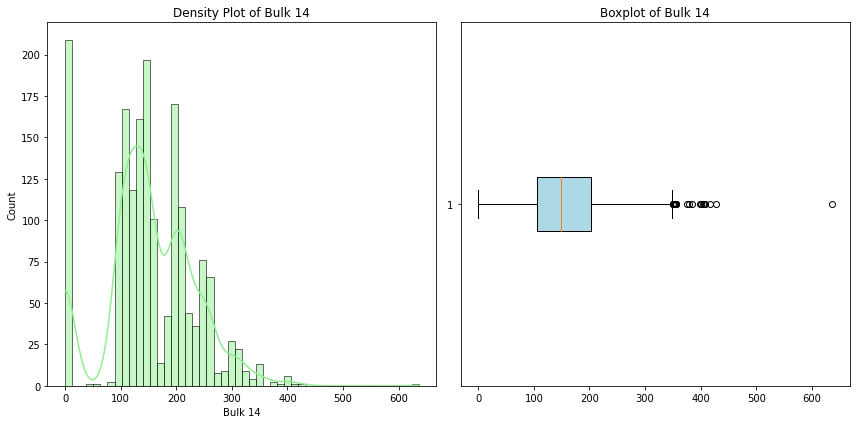

Statics for Bulk 12


,count,mean,std,min,25%,50%,75%,max
Bulk 12,1746.0,204.86827,155.338377,0.0,105.0,206.0,261.75,1849.0


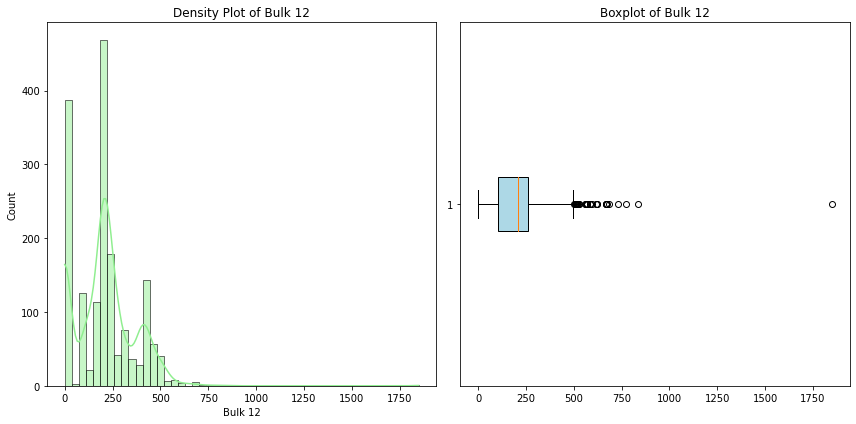

Statics for PowerFactor_min


,count,mean,std,min,25%,50%,75%,max
PowerFactor_min,1746.0,0.773803,0.023129,0.707722,0.755837,0.772666,0.790121,0.857042


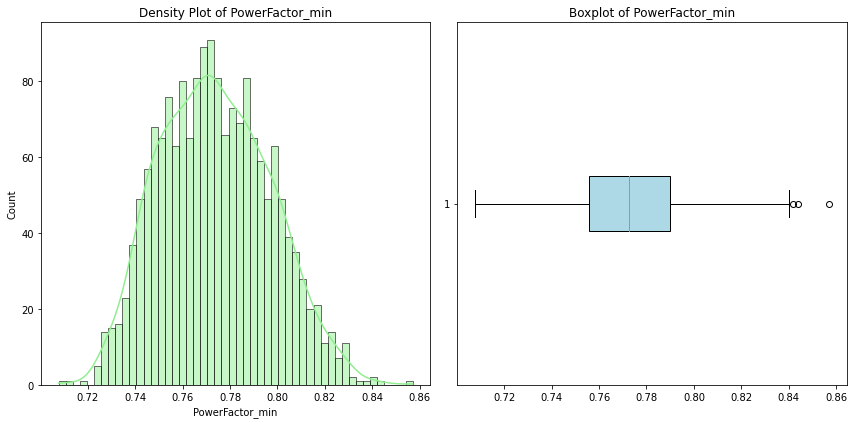

Statics for BulkFeedingDuration_sec


,count,mean,std,min,25%,50%,75%,max
BulkFeedingDuration_sec,1746.0,981.056128,832.546053,0.0,486.25,887.0,1337.0,13683.0


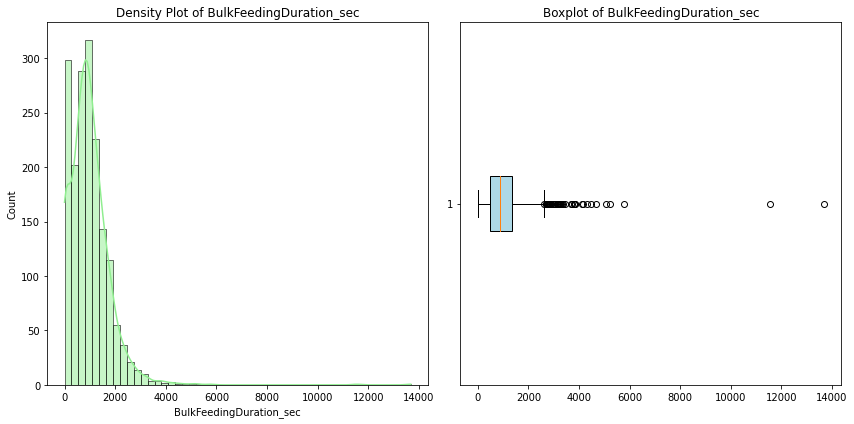

Statics for BeginHeat_min


,count,mean,std,min,25%,50%,75%,max
BeginHeat_min,1746.0,1.561095e+09,2.455270e+06,1.556883e+09,1.558970e+09,1.561038e+09,1.562881e+09,1.565444e+09


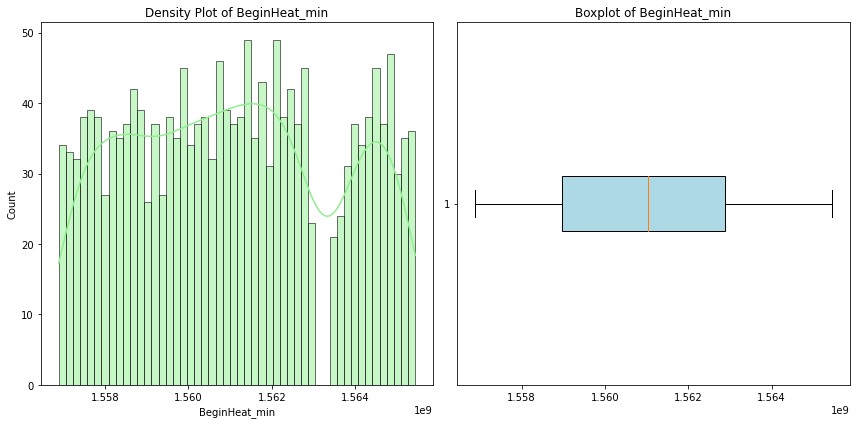

Statics for EndHeat_max


,count,mean,std,min,25%,50%,75%,max
EndHeat_max,1746.0,1.561097e+09,2.455246e+06,1.556884e+09,1.558971e+09,1.561040e+09,1.562883e+09,1.565445e+09


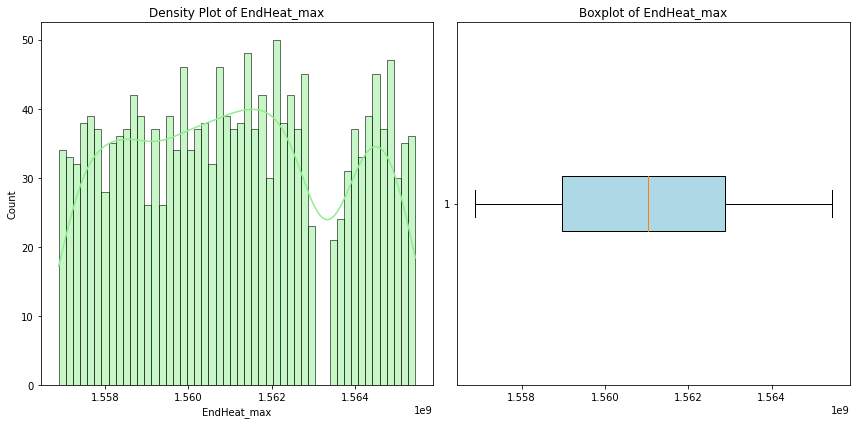

Statics for BulkFeeding_AvgInterval_sec


,count,mean,std,min,25%,50%,75%,max
BulkFeeding_AvgInterval_sec,1746.0,340.955441,252.301775,0.0,201.666667,312.333333,448.645833,3420.75


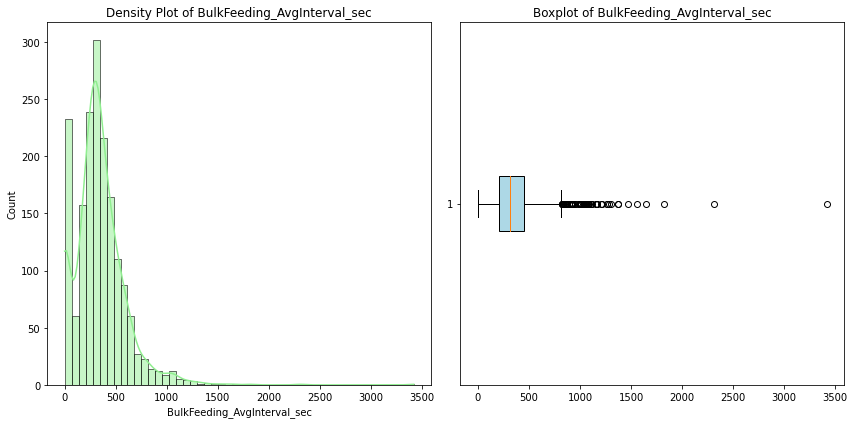

Statics for Bulk 7


,count,mean,std,min,25%,50%,75%,max
Bulk 7,1746.0,2.399198,34.026627,0.0,0.0,0.0,0.0,772.0


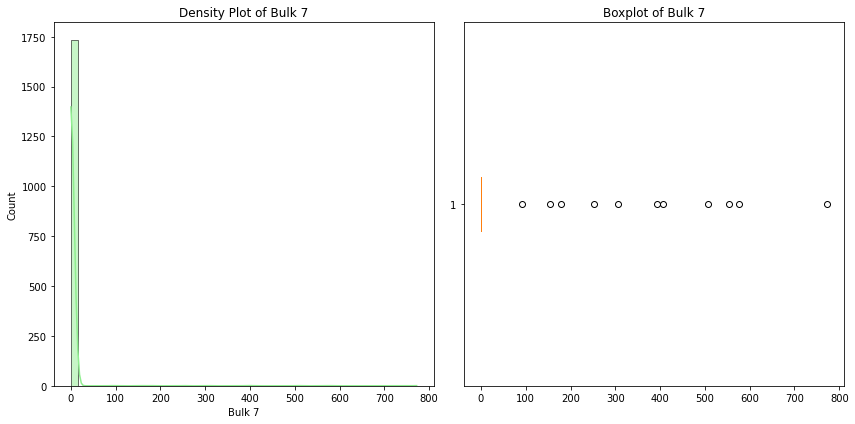

Statics for RatioPower_mean


,count,mean,std,min,25%,50%,75%,max
RatioPower_mean,1746.0,1.371276,0.065668,1.109868,1.328998,1.371553,1.415312,1.663366


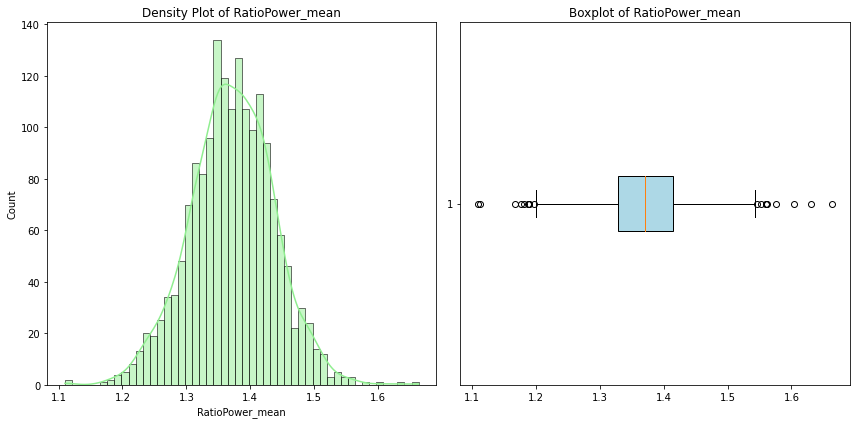

Statics for ActivePower_min


,count,mean,std,min,25%,50%,75%,max
ActivePower_min,1746.0,0.421794,0.118799,0.223895,0.332152,0.408776,0.481421,1.140738


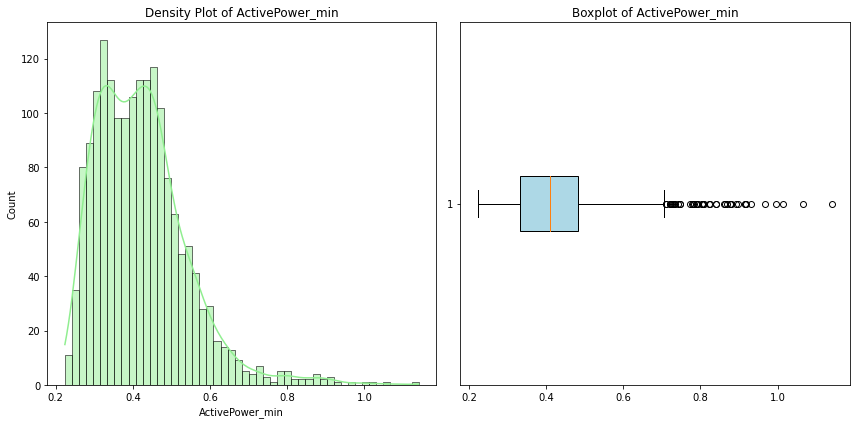

Statics for ReactivePower_min


,count,mean,std,min,25%,50%,75%,max
ReactivePower_min,1746.0,0.306056,0.088169,0.153777,0.239467,0.293058,0.351668,0.860854


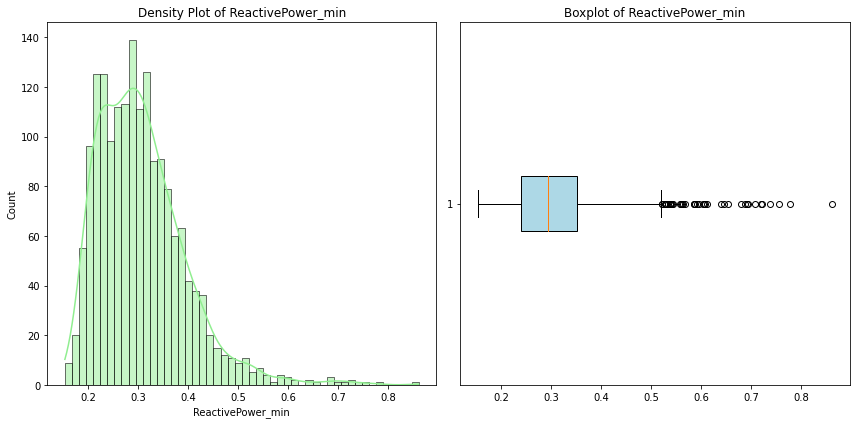

Statics for ReactivePower_max


,count,mean,std,min,25%,50%,75%,max
ReactivePower_max,1746.0,0.721535,0.185815,0.196228,0.58509,0.720176,0.854371,1.270284


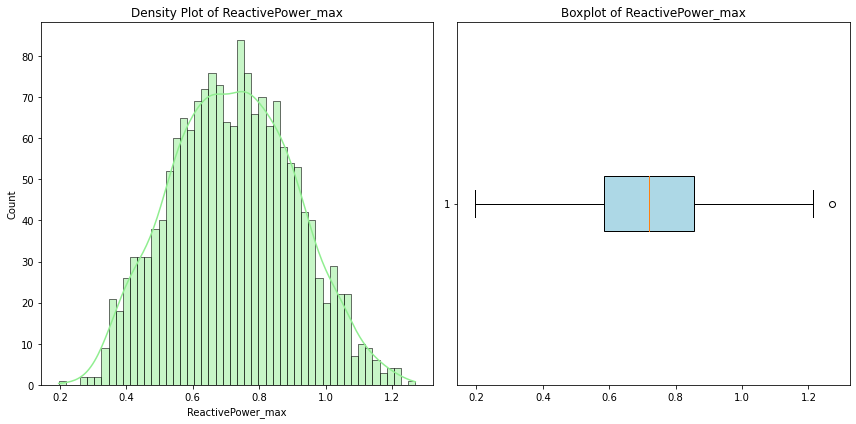

Statics for PowerFactor_mean


,count,mean,std,min,25%,50%,75%,max
PowerFactor_mean,1746.0,0.805438,0.013873,0.74228,0.796785,0.805932,0.814907,0.857042


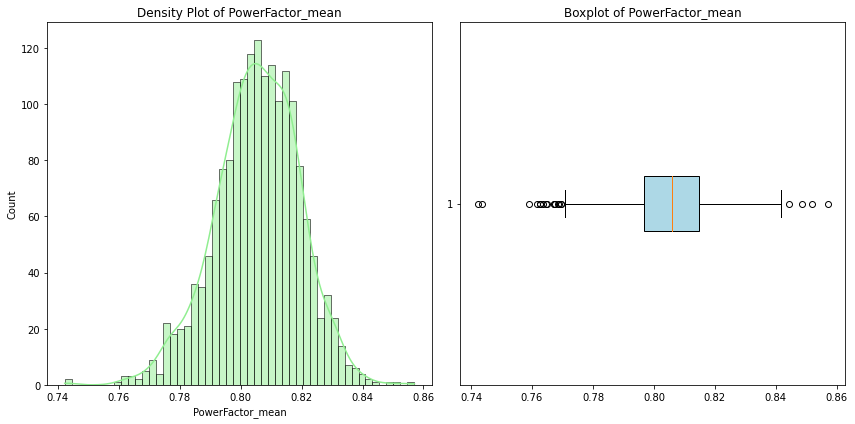

Statics for WireFeedingDuration_sec


,count,mean,std,min,25%,50%,75%,max
WireFeedingDuration_sec,1746.0,219.506873,391.224779,0.0,0.0,0.0,407.75,5492.0


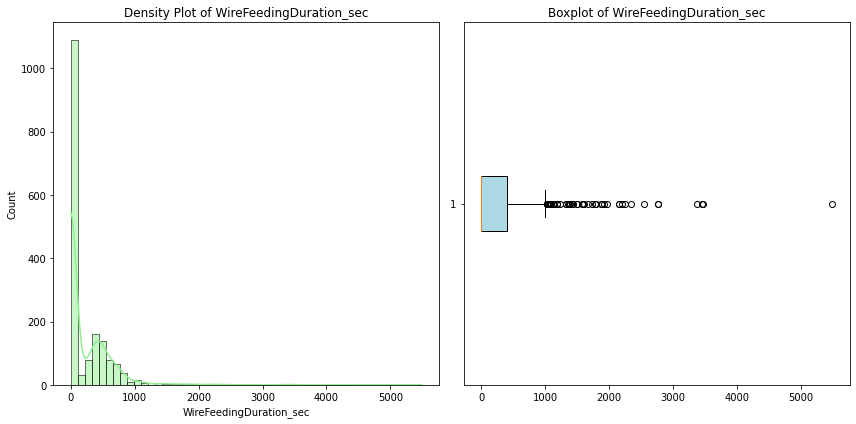

Statics for Bulk 3


,count,mean,std,min,25%,50%,75%,max
Bulk 3,1746.0,47.231959,75.784936,0.0,0.0,0.0,79.0,445.0


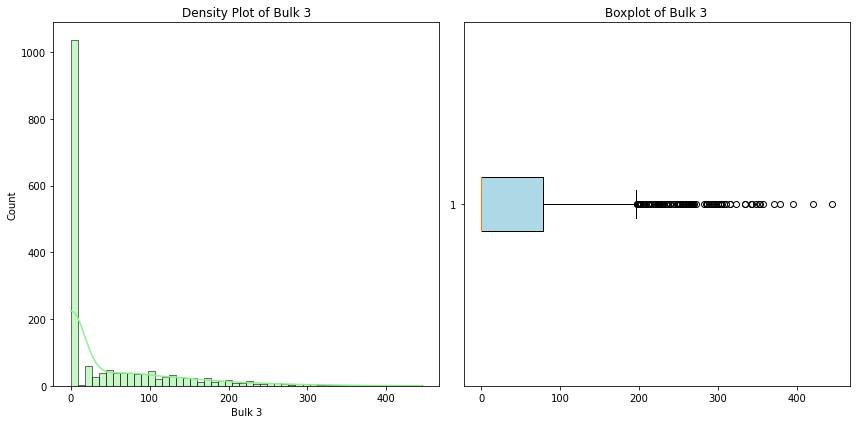

Statics for Bulk 4


,count,mean,std,min,25%,50%,75%,max
Bulk 4,1746.0,37.137457,58.189509,0.0,0.0,0.0,79.0,276.0


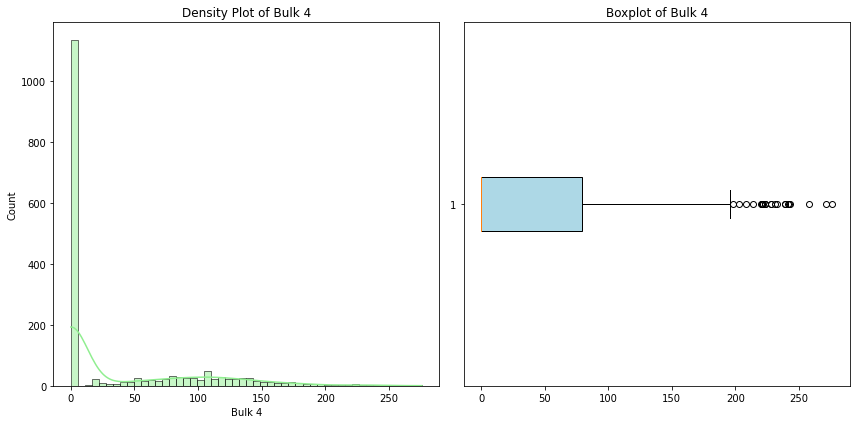

Statics for ActivePower_max


,count,mean,std,min,25%,50%,75%,max
ActivePower_max,1746.0,0.967569,0.233772,0.267676,0.799321,0.972087,1.156373,1.463773


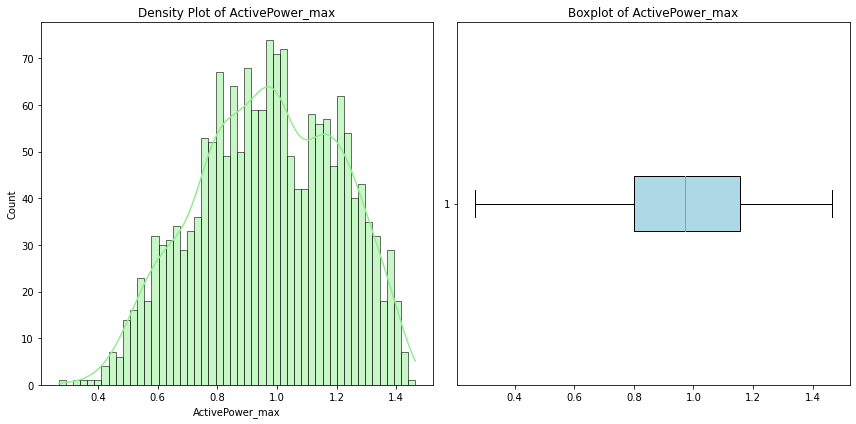

Statics for ReactivePower_mean


,count,mean,std,min,25%,50%,75%,max
ReactivePower_mean,1746.0,0.489436,0.098876,0.196228,0.420081,0.48458,0.546867,0.960763


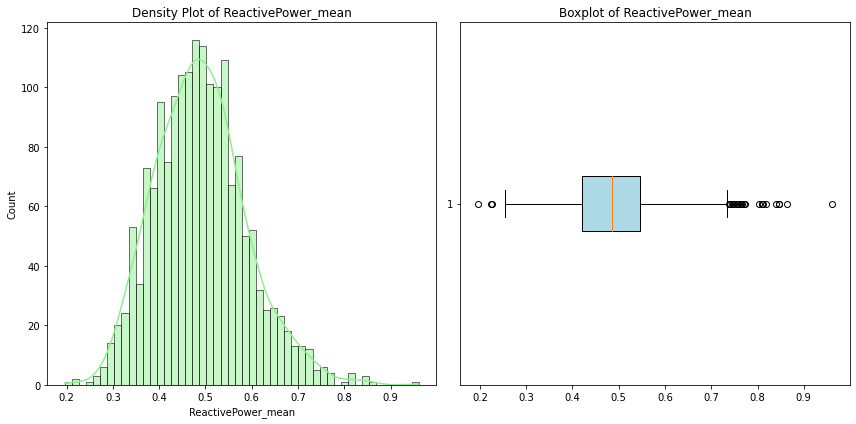

Statics for TotalPower_min


,count,mean,std,min,25%,50%,75%,max
TotalPower_min,1746.0,0.523413,0.147125,0.275718,0.413319,0.506031,0.599131,1.429109


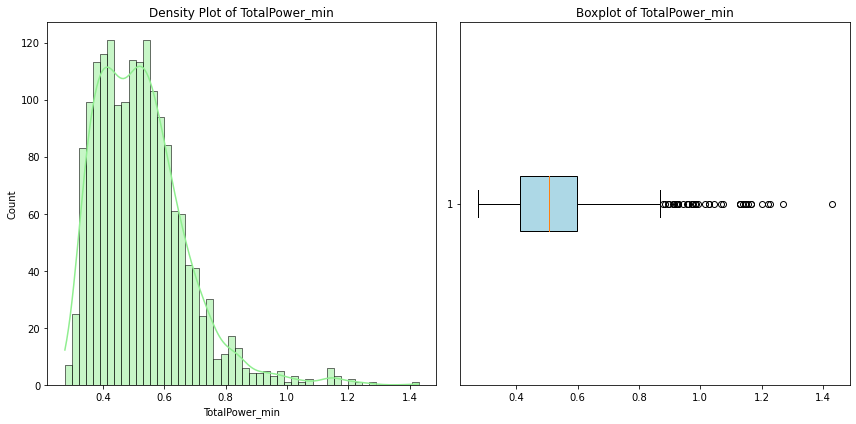

Statics for ActivePower_mean


,count,mean,std,min,25%,50%,75%,max
ActivePower_mean,1746.0,0.664719,0.129851,0.267676,0.573967,0.654743,0.744899,1.243889


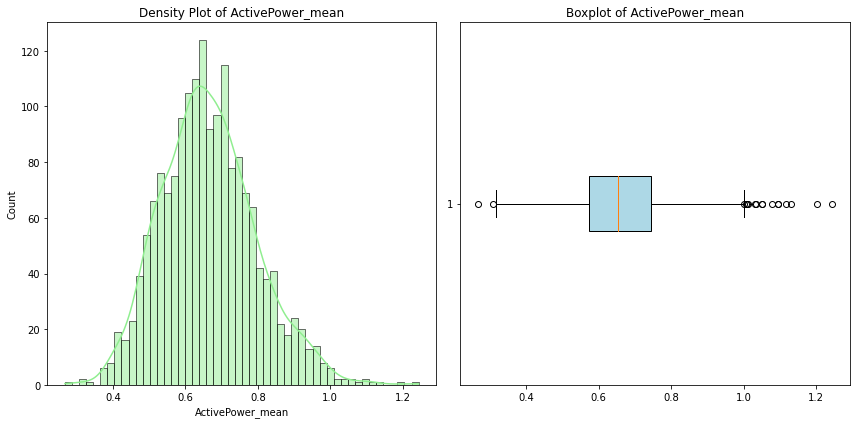

Statics for NumHeats_first


,count,mean,std,min,25%,50%,75%,max
NumHeats_first,1746.0,4.68614,1.635565,1.0,4.0,5.0,6.0,16.0


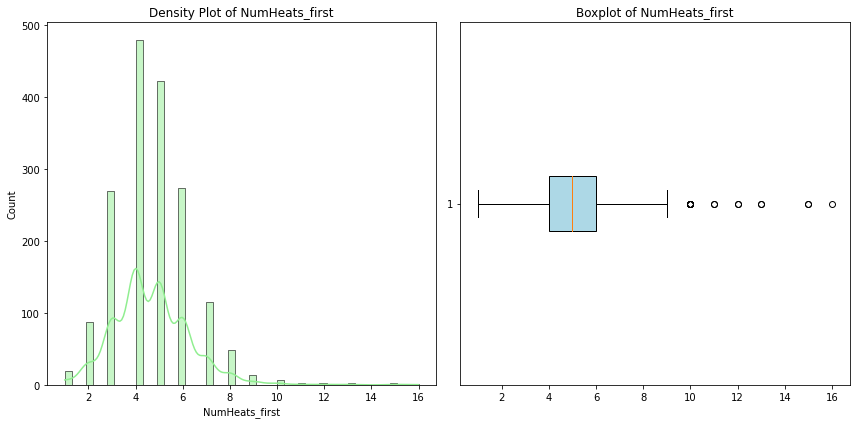

In [98]:
for col in X_train.columns:
  show_stats(X_train, col)
  plot_density_and_boxplot(X_train, col)

Можно попробовать пролагорифмировать данные перед подачей линейной моделе.

UPD - без этого метрика лучше.

In [99]:
# cols_to_exclude = ['NumHeats_first',
#                    'ActivePower_mean',
#                    'ReactivePower_mean',
#                    'PowerFactor_mean',
#                    'ReactivePower_max',
#                    'RatioPower_mean',
#                    'PowerFactor_min',
#                    'FirstTemperature']

# for col in X_train.drop(columns=cols_to_exclude).columns:
#   X_train[col] = np.log(X_train[col] + 1)

<AxesSubplot:title={'center':'Features Correlation'}>

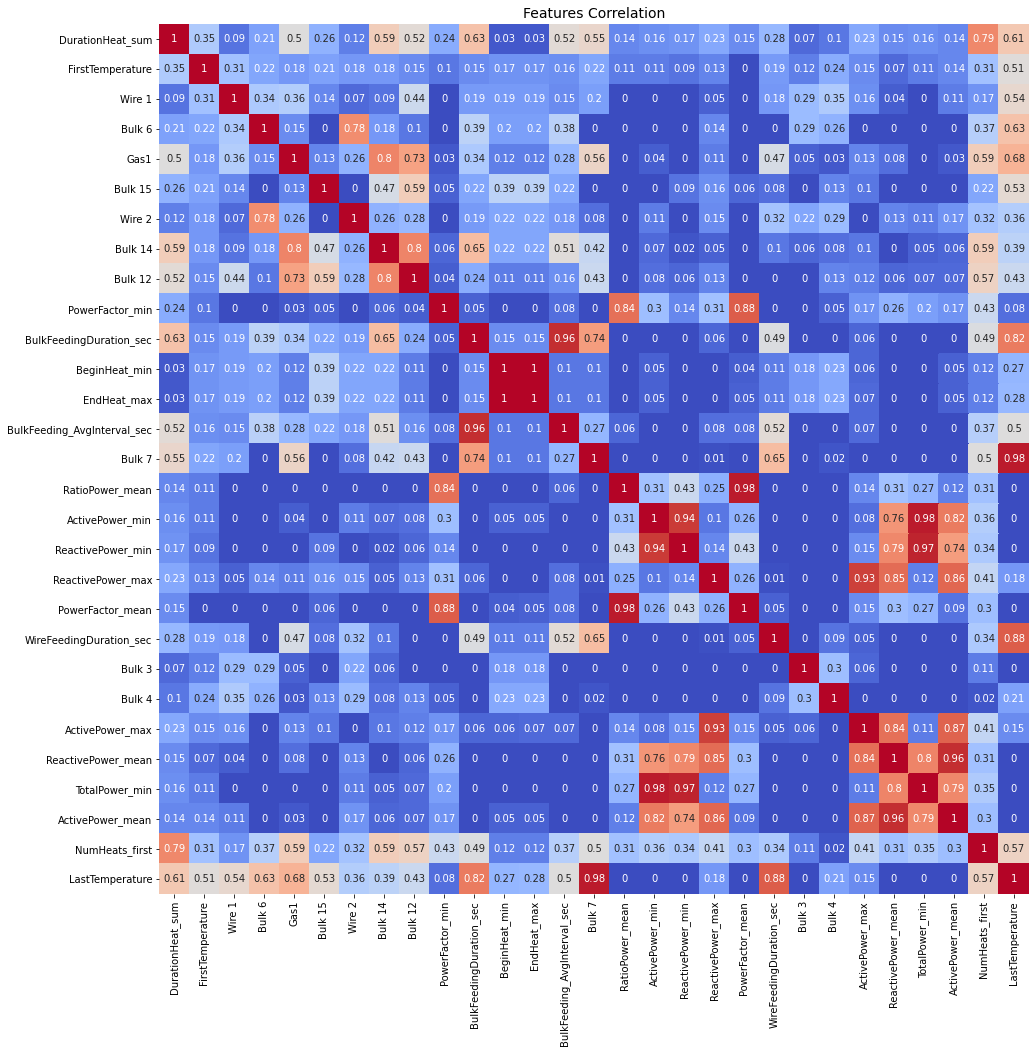

In [100]:
INTERVAL_COLS = X_train.columns

matrix = df_selected.phik_matrix(interval_cols=INTERVAL_COLS)
plt.figure(figsize=(16, 16))
plt.title('Features Correlation',
          fontsize=14)
sns.heatmap(matrix.round(2),
            annot = True, square=True,
            cmap='coolwarm',
            cbar=False)

Корреляция = 1 у признаков BeginHeat_min и EndHeat_max.

Однако, даже коррелирующие признаки могут несли информацию.

На данном этапе вместо удаления признаков по корреляции, попробую подобрать регуляризацию (например, Ridge или Lasso регрессию).

UPD - это было верным решением.


Корреляция с LastTemperature:
Wire 1                         0.317575
FirstTemperature               0.301320
DurationHeat_sum               0.278716
Bulk 12                        0.267424
Bulk 15                        0.266414
Bulk 4                         0.187970
NumHeats_first                 0.181146
Bulk 14                        0.114617
BulkFeedingDuration_sec        0.111748
BulkFeeding_AvgInterval_sec    0.098359
ActivePower_max                0.069268
Gas1                           0.059160
ReactivePower_max              0.054401
ActivePower_mean               0.040216
ReactivePower_mean             0.032770
PowerFactor_mean               0.015838
RatioPower_mean                0.013954
ReactivePower_min             -0.019445
PowerFactor_min               -0.024679
TotalPower_min                -0.025481
ActivePower_min               -0.029738
Bulk 3                        -0.035977
EndHeat_max                   -0.099433
BeginHeat_min                 -0.099495
Bulk 7    

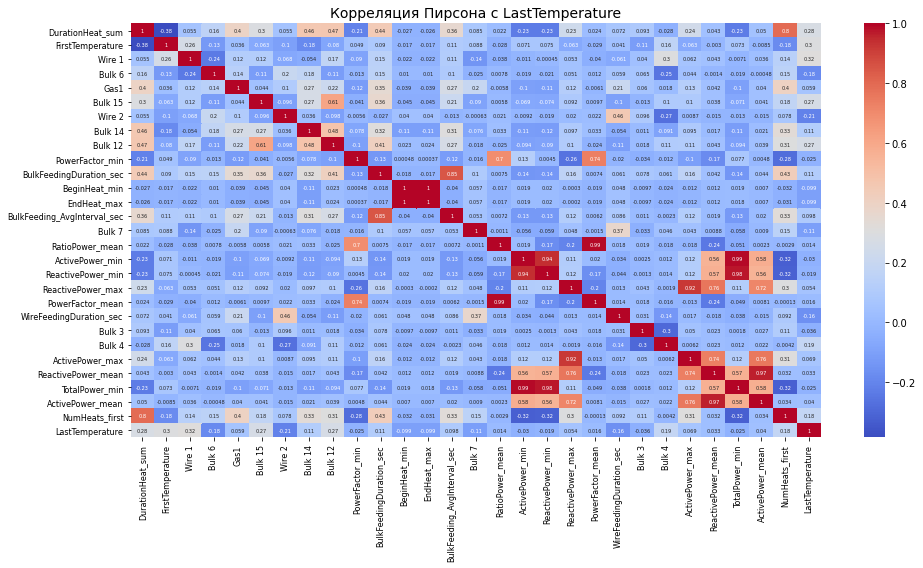

In [101]:
# корреляция Пирсона
correlation = df_selected.corr(method='pearson')['LastTemperature'].sort_values(ascending=False)

# Таблица с корреляций с таргетом
print("Корреляция с LastTemperature:")
print(correlation.drop('LastTemperature'))  # Исключаем таргет

# Визуализация
plt.figure(figsize=(14, 8))  # Ширина x Высота в дюймах
sns.heatmap(df_selected.corr(), annot=True, cmap='coolwarm', annot_kws={"size": 5})  # annot_kws увеличивает размер чисел
plt.title("Корреляция Пирсона с LastTemperature", fontsize=14)
plt.xticks(fontsize=8)  # Размер подписей осей X
plt.yticks(fontsize=8)  # Размер подписей осей Y
plt.tight_layout()  # Автоматическая подгонка элементов
plt.show()

In [102]:
# ======== Preprocessor (numeric values only) ========
preprocessor = ColumnTransformer(transformers=[
    ('scaler', MinMaxScaler(), X_train)
])

# ======== Pipeline with model ========
linear_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.001, random_state=RANDOM_STATE))
])

# ======== Parameters for Randomized Search ========
param_grid = [
    {
        'regressor': [Lasso(alpha=0.001, random_state=RANDOM_STATE)],
        'preprocessor': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'regressor': [Ridge(alpha=0.001, random_state=RANDOM_STATE)],
        'preprocessor': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    {
        'regressor': [ElasticNet(alpha=0.001, random_state=RANDOM_STATE)],
        'preprocessor': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [103]:
# ======== Search for optimal params  ========
search_lin = RandomizedSearchCV(
    estimator = linear_pipe,
    param_distributions = param_grid,
    n_iter=9,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

In [104]:
search_lin.fit(X_train, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6183.066004394335, tolerance: 17.335626575931244
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8472.889932912403, tolerance: 16.574715676449532
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134.61578570798156, tolerance: 17.763394989262707
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               MinMaxScaler(),
                                                                                     DurationHeat_sum  FirstTemperature      Wire 1  Bulk 6       Gas1  \
1433             813.0            1558.0    0.000000     0.0  18.137567   
573              715.0            1601.0  103.942802     0.0  11.838655   
939              738.0            1569.0   85.129196   252.0  12.096320   
1375             795.0            1547.0  152.099991     0.0   9.586852   
2116            1261.0            1558.0  100.201920     0.0   7.94721...
                                         'regressor': [Lasso(alpha=0.001,
                                                             random_state=210425)]},
                                        {'

In [105]:
print("Best parameters:", search_lin.best_params_)
print("Best MAE:", -search_lin.best_score_)

Best parameters: {'regressor': Ridge(alpha=0.001, random_state=210425), 'preprocessor': 'passthrough'}
Best MAE: 5.988146976436326


In [106]:
# c удалением одного из коррелирующих признаков
# X_train_ = X_train.drop(columns='BeginHeat_min')
# search_lin.fit(X_train_, y_train)
# print("Best parameters:", search_lin.best_params_)
# print("Best MAE:", -search_lin.best_score_)

В целом, метрика удовлетворительная и соответствует ТЗ.

# 4.4. Деревянные модели

In [107]:
# ======== Pipeline with preprocessing and model ========
tree_pipe = Pipeline(steps=[
    ('estimator', RandomForestRegressor(random_state=RANDOM_STATE))
])

# ======== Params for Search ========
param_grid = [
    {
        'estimator': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'estimator__max_depth': range(3, 15),
        'estimator__min_samples_split': range(2, 10),
        'estimator__min_samples_leaf': range(1, 10)
    },
    {
        'estimator': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'estimator__n_estimators': [50, 100, 200],
        'estimator__max_depth': [None, 5, 10, 15],
        'estimator__min_samples_split': [2, 5, 10],
        'estimator__min_samples_leaf': [1, 2, 4],
        'estimator__max_features': ['auto', 'sqrt', 'log2']
    }
]

In [108]:
# ======== Search for optimal params  ========
search_tree = RandomizedSearchCV(
    estimator = tree_pipe,
    param_distributions = param_grid,
    n_iter=10,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE
)

In [109]:
search_tree.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('estimator',
                                              RandomForestRegressor(random_state=210425))]),
                   n_jobs=-1,
                   param_distributions=[{'estimator': [DecisionTreeRegressor(random_state=210425)],
                                         'estimator__max_depth': range(3, 15),
                                         'estimator__min_samples_leaf': range(1, 10),
                                         'estimator__min_samples_split': range(2, 10)},
                                        {'estimator': [RandomForestRegressor(max_depth=10,
                                                                             min_samples_leaf=4,
                                                                             min_samples_split=10,
                                                                             random_state=210425)],
                                         'estimator__

In [110]:
print("Best parameters:", search_tree.best_params_)
print("Best MAE:", -search_tree.best_score_)

Best parameters: {'estimator__n_estimators': 100, 'estimator__min_samples_split': 10, 'estimator__min_samples_leaf': 4, 'estimator__max_features': 'auto', 'estimator__max_depth': 10, 'estimator': RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      random_state=210425)}
Best MAE: 6.313972180506622


Ожидаемо, что из деревянных моделей, лучше покажет себя случайный лес.

Однако, метрика хуже, чем у линейной модели.

# 4.5. Бустинг

In [111]:
if get_gpu_device_count() > 0:
    task_type = 'GPU'
else:
    task_type = 'CPU'

print("CatBoost will use:", task_type)

CatBoost will use: CPU


Error 35 (CUDA driver version is insufficient for CUDA runtime version) ignored while obtaining device count


In [112]:
# ======== Pipeline с CatBoost и MAE ========
boost_pipe = Pipeline(steps=[
    ('model', CatBoostRegressor(random_state=RANDOM_STATE, verbose=0, task_type=task_type))  # Модель CatBoost с GPU
])

# ======== Подбор гиперпараметров с RandomizedSearchCV ========
param_dist = {
    'model__iterations': [100, 200, 300],
    'model__depth': [4, 6, 8],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__l2_leaf_reg': [1, 3, 5]
}

random_search = RandomizedSearchCV(
    boost_pipe,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    scoring='neg_mean_absolute_error',  # исправлено
    random_state=RANDOM_STATE,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Получаем лучшие параметры
print(f"Best parameters: {random_search.best_params_}")
print(f"Mean Absolute Error (MAE): {-random_search.best_score_}")

Best parameters: {'model__learning_rate': 0.1, 'model__l2_leaf_reg': 1, 'model__iterations': 300, 'model__depth': 4}
Mean Absolute Error (MAE): 6.087668466783949


Неплохой результат у бустинга. Также, соответствует ТЗ.

# 4.6. Нейронная сеть

In [113]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)

X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train_split.values)

X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.values)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 1)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = MyModel()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
best_loss = float('inf')
patience = 20
counter = 0

for epoch in range(1, n_epochs+1):
  model.train()
  for X_batch, y_batch in train_loader:
    optimizer.zero_grad()
    predictions = model(X_batch)
    loss = criterion(predictions, y_batch)
    loss.backward()
    optimizer.step()

  model.eval()

  with torch.no_grad():
    for X_batch, y_batch in val_loader:
      predictions_val = model(X_batch)
      loss_val = criterion(predictions_val, y_batch).item()
      loss_val += loss_val

  val_loss = loss_val / len(val_loader)
  print(f'Epoch {epoch}, Val Loss: {val_loss}')

  if val_loss < best_loss:
    best_loss = val_loss
    counter = 0
  else:
    counter += 1

  if counter >= patience:
    print(f'Early stopping at epoch: {epoch}')

Epoch 1, Val Loss: 288.8714710582386
Epoch 2, Val Loss: 286.09965376420456


/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.9/site-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, 

Epoch 3, Val Loss: 280.82639382102275
Epoch 4, Val Loss: 264.7435857599432
Epoch 5, Val Loss: 242.5794344815341
Epoch 6, Val Loss: 201.90092329545453
Epoch 7, Val Loss: 146.4502507990057
Epoch 8, Val Loss: 95.62143776633523
Epoch 9, Val Loss: 78.18312766335227
Epoch 10, Val Loss: 68.32181618430398
Epoch 11, Val Loss: 54.32916259765625
Epoch 12, Val Loss: 62.15343683416193
Epoch 13, Val Loss: 52.07731489701705
Epoch 14, Val Loss: 52.45064475319602
Epoch 15, Val Loss: 37.60531893643466
Epoch 16, Val Loss: 35.60730535333807
Epoch 17, Val Loss: 40.114843195134945
Epoch 18, Val Loss: 38.52287431196733
Epoch 19, Val Loss: 34.40934892134233
Epoch 20, Val Loss: 31.85928899591619
Epoch 21, Val Loss: 38.96098188920455
Epoch 22, Val Loss: 32.55943991921165
Epoch 23, Val Loss: 34.11212158203125
Epoch 24, Val Loss: 34.14379050514915
Epoch 25, Val Loss: 30.592673561789773
Epoch 26, Val Loss: 32.58110462535512
Epoch 27, Val Loss: 25.472836581143465
Epoch 28, Val Loss: 27.560577392578125
Epoch 29, Val

Результат весьма неплохой, однако, учитвая небольшое количество данных, сеть вероятно очень сильно переобучилась.

Для проверки качества модели на тестовой выборке выбиру линейную регрессию.

# Проверка модели

Проверку осуществляю на линейной модели Ridge.

In [114]:
predictions = search_lin.predict(X_test)
mae_test = mean_absolute_error(y_test, predictions)
print(f'MAE на тестовой выборке: {mae_test}')

MAE на тестовой выборке: 6.154125666943429


Сравним с константной моделью

In [115]:
y_pred_dummy = dummy_model.predict(X_test)

mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
print(f'MAE Dummy Regressor = {mae_dummy}')

MAE Dummy Regressor = 8.153378759389257


Метрика линейной модели соответствует ТЗ, а также ниже чем у константной модели.

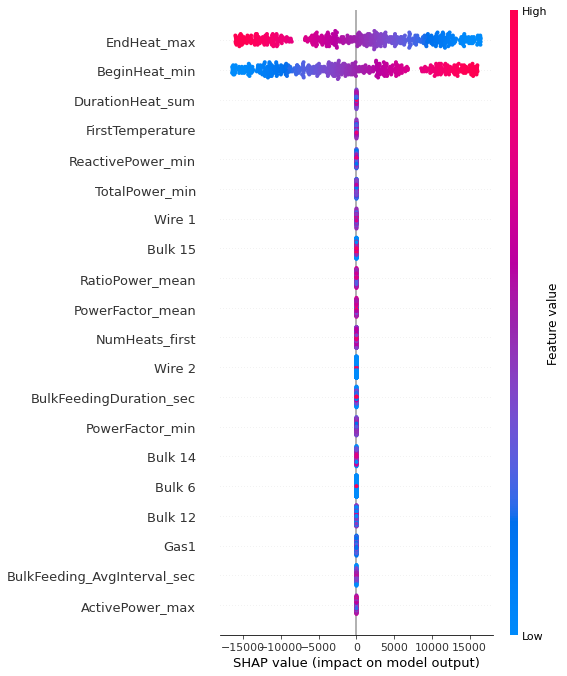

In [116]:
best_model = search_lin.best_estimator_

model = best_model.named_steps['regressor']

explainer = LinearExplainer(model, X_train, feature_names=X_train.columns)
shap_values = explainer.shap_values(X_test)

summary_plot(shap_values, X_test, feature_names=X_test.columns)

Среди самых важных признаков модель выделяет два синтетических признака:

- Максимальная величина полученная в результате аггрегирования таймстемпа завершения нагрева дугой и переведённая в числовой формат.

- Минимальная величина полученная в результате аггрегирования таймстемпа начала нагрева дугой и переведённая в числовой формат.

Вышеуказанные величины буду плохо интерпретироваться, т.к. получены синтетически. Поэтому, также проанализируем прочие важные признаков.

Модель также считает важным общую длительность нагрева, а также начальную температуру.

Посмотрим визуализацию.

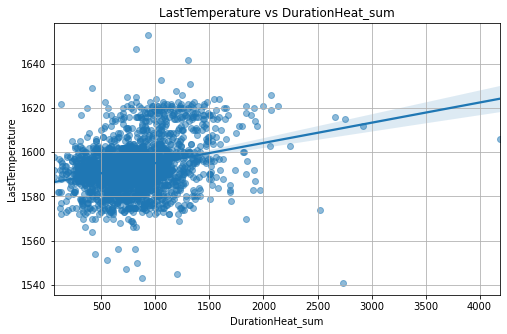

In [117]:
plt.figure(figsize=(8, 5))
sns.regplot(x='DurationHeat_sum', y='LastTemperature', data=df_selected, scatter_kws={'alpha': 0.5})
plt.title('LastTemperature vs DurationHeat_sum')
plt.grid(True)
plt.show()

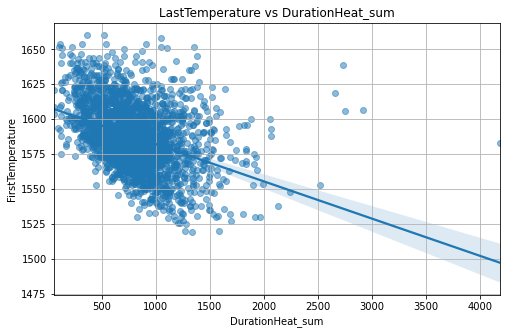

In [118]:
plt.figure(figsize=(8, 5))
sns.regplot(x='DurationHeat_sum', y='FirstTemperature', data=df_selected, scatter_kws={'alpha': 0.5})
plt.title('LastTemperature vs DurationHeat_sum')
plt.grid(True)
plt.show()

Как было видно из матрицы корреляции, наблюдается умеренная корреляция (положительная в первом случае и отрицательная во втором).

# Общий вывод по работе

Целью настоящего проекта являлась оптимизация производственных расходов, стояла задача прогнозирования финальной температуры стали в ковше.

В качестве исходных данных были использованы данные Заказчика из нескольких таблиц (данные об электродах; данные об объёме сыпучих материалов; данные о времени подачи сыпучих материалов; данные о продувке сплава газом; данные об измерениях температуры; данные об объёме проволочных материалов; данные о времени подачи проволочных материалов).

В ходе обучения приемлемый результат оказался у всех моделей.

Однако, из-за наличия только численных признаков в качестве лучшей модели была выбрана линейная регрессия с регуляризацией, мае на тесте - 6.3

Рекомендации заказчику

Существенное влияние на температуру оказали искуственные признаки, однако, среди не синтетических лидирует начальная температура, что говорит о том, что Заказчику стоит уделить особое внимание датчикам, замеряющим начальную температуру.